<a href="https://colab.research.google.com/github/quaneh/fnma-predictor/blob/main/fnma_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports
* As this notebook is designed to be ran in Google Colab, we must first mount our Google Drive to access data there.
* We then need to download NVIDIA RAPIDS, and OPTUNA (for hyperparameter tuning)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 395 (delta 92), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (395/395), 108.50 KiB | 841.00 KiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.3 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import cudf
import optuna

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error

from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.ensemble import RandomForestRegressor as cuRFR
from cuml.metrics import accuracy_score

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Load and Process Data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data/2007Q4_NO_DUP_NA_SCRUB.csv', index_col=0)

Remove columns that will not contribute to our model

In [ ]:
drop_cols = ['LOAN_ID','PPMT_FLG', 'IO', 'Zero_Bal_Code', 'ZB_DTE', 'LAST_UPB','RE_PROCS_FLAG', 'PRODUCT', 'HOMEREADY_PROGRAM_INDICATOR', 'HIGH_BALANCE_LOAN_INDICATOR',
             'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR', ]
df = df.drop(drop_cols, axis=1)

Remove further columns that could not be known before the loan is approved or disapproved.

Delinquency status can only be know for a loan that has been approved and is now being repaid, and the same applies for Current Unpaid Balance.

In [ ]:
drop_cols = ['DLQ_STATUS', 'CURRENT_UPB']
df = df.drop(drop_cols, axis=1)

In [ ]:
df

,ACT_PERIOD,CHANNEL,SELLER,ORIG_RATE,ORIG_UPB,ORIG_TERM,ORIG_DATE,FIRST_PAY,OLTV,OCLTV,...,FIRST_FLAG,PURPOSE,PROP,NO_UNITS,OCC_STAT,STATE,MSA,ZIP,RELOCATION_MORTGAGE_INDICATOR,HAS_DEFAULTED
0,12009,C,"Bank Of America, N.A.",6.625,343000.0,360,102007,122007,86,86.0,...,N,C,PU,1,P,CO,17820,809.0,N,0
1,82013,C,"Bank Of America, N.A.",6.250,400000.0,360,102007,122007,62,62.0,...,N,P,SF,1,P,CA,41740,920.0,N,0
2,102021,B,Other,6.625,81000.0,360,112007,12008,64,82.0,...,N,R,SF,1,P,LA,12940,708.0,N,0
3,122015,B,Amtrust Bank,6.500,119000.0,360,112007,12008,71,71.0,...,N,R,CO,1,P,IL,16980,600.0,N,0
4,62019,B,"Bank Of America, N.A.",6.625,205000.0,360,102007,122007,27,27.0,...,N,C,SF,1,P,CA,31080,907.0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391178,52008,R,Other,6.500,139000.0,360,112007,12008,58,58.0,...,N,P,PU,1,P,MO,28140,641.0,N,0
391179,62009,R,Other,6.375,47000.0,180,12007,32007,76,76.0,...,N,R,SF,1,P,OH,17460,441.0,N,0
391180,22015,C,"Citimortgage, Inc.",6.125,135000.0,360,112007,12008,56,56.0,...,N,P,CO,1,I,CA,37100,913.0,N,0
391181,12010,B,"Bank Of America, N.A.",6.250,344000.0,360,112007,12008,80,80.0,...,N,C,SF,1,P,PA,0,155.0,N,0


Split dates into month and year.

In [ ]:
df['ACT_PERIOD_YEAR'] = df['ACT_PERIOD'].apply(lambda x: str(x)[-4:]).astype(int)
df['ACT_PERIOD_MONTH'] = df['ACT_PERIOD'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['ACT_PERIOD'], axis=1)

In [ ]:
df['ORIG_DATE_YEAR'] = df['ORIG_DATE'].apply(lambda x: str(x)[-4:]).astype(int)
df['ORIG_DATE_MONTH'] = df['ORIG_DATE'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['ORIG_DATE'], axis=1)

In [ ]:
df['FIRST_PAY_YEAR'] = df['FIRST_PAY'].apply(lambda x: str(x)[-4:]).astype(int)
df['FIRST_PAY_MONTH'] = df['FIRST_PAY'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['FIRST_PAY'], axis=1)

Replace whitespace in SELLER values and make lowercase

In [ ]:
df['SELLER'].replace(' ', '_', regex=True, inplace=True)
df['SELLER'].replace('\.', '', regex=True, inplace=True)
df['SELLER'].replace('\,', '', regex=True, inplace=True)
df['SELLER'] = df['SELLER'].str.lower()


Get Latitude and Longitude for each ZIP code so that we can use numeric values.

Areas that are close together will have Lat/Long values that are also close together. It's possible that certain regions have higher rates of default than others.

In [ ]:
zip_code_map = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data/zip_lat_long.csv', sep=',', header=0,
                           names=['ZIP', 'LAT', 'LONG'], dtype={'ZIP': str})

zip_code_map['ZIP'] = zip_code_map['ZIP'].apply(lambda x: x[:3])

zip_code_map = zip_code_map.groupby('ZIP')[['LAT', 'LONG']].mean().reset_index()

df['ZIP'] = df['ZIP'].astype(int).astype(str).str.zfill(3)

df = df.merge(zip_code_map, on='ZIP', how='left')

df.drop(['ZIP', 'STATE', 'MSA'], axis=1, inplace=True)

### Replace Null Values

Note: Here we replace all null values with 0 as we have decided on XGBoost as our chosen model. We also experimented with imputed values.

In [ ]:
# Saving data for convenience when trying alternative methods of handling nulls
df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Data/2007Q4_processed_w_nulls.csv")

In [ ]:
df['DTI'].fillna(0, inplace=True)
df['CSCORE_B'].fillna(0, inplace=True)
df['CSCORE_C'].fillna(0, inplace=True)
df['FIRST_FLAG'].fillna('XX', inplace=True)
df['NUM_BO'].fillna(0, inplace=True)
df['OCLTV'].fillna(0, inplace=True)
df['LAT'].fillna(0, inplace=True)
df['LONG'].fillna(0, inplace=True)

In [ ]:
df = df[df['ORIG_RATE'].notnull()]

In [ ]:
df.dtypes

CHANNEL                           object
SELLER                            object
ORIG_RATE                        float64
ORIG_UPB                         float64
ORIG_TERM                          int64
OLTV                               int64
OCLTV                            float64
NUM_BO                           float64
DTI                              float64
CSCORE_B                         float64
CSCORE_C                         float64
FIRST_FLAG                        object
PURPOSE                           object
PROP                              object
NO_UNITS                           int64
OCC_STAT                          object
RELOCATION_MORTGAGE_INDICATOR     object
HAS_DEFAULTED                      int64
ACT_PERIOD_YEAR                    int64
ACT_PERIOD_MONTH                   int64
ORIG_DATE_YEAR                     int64
ORIG_DATE_MONTH                    int64
FIRST_PAY_YEAR                     int64
FIRST_PAY_MONTH                    int64
LAT             

We can use the following visualisation for exploring our dataset.

Change the *column* to view how default rates vary for different values for that feature.

Text(0, 0.5, 'NUM_BO')

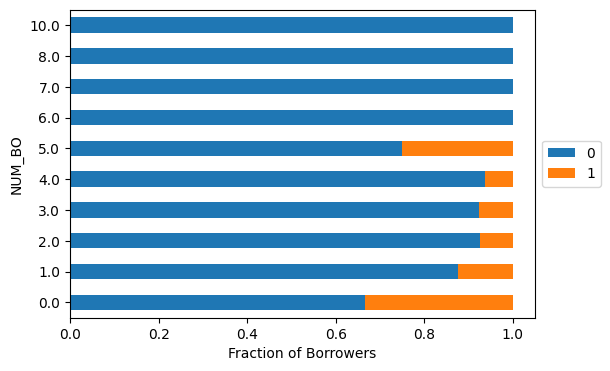

In [ ]:
column = 'NUM_BO'

data = df.loc[df[column].isin(df[column].value_counts().index.tolist()[:10])]

xtab = pd.pivot_table(data, index=column, columns='HAS_DEFAULTED', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, figsize=(6,4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Fraction of Borrowers')
plt.ylabel(column)

### Processing

* Here we split our dataset into X and y (predictor variables and target variable)

* We check that we no longer have any null values in our dataset.

* We then convert the non-numerical data to the category type

In [ ]:
y = df['HAS_DEFAULTED'].copy()
X = df.drop(['HAS_DEFAULTED'], axis=1).copy()

In [ ]:
X.columns = map(str.lower, X.columns)
X.iloc[0].to_json()

'{"channel":"C","seller":"bank_of_america_na","orig_rate":6.625,"orig_upb":343000.0,"orig_term":360,"oltv":86,"ocltv":86.0,"num_bo":2.0,"dti":27.0,"cscore_b":751.0,"cscore_c":756.0,"first_flag":"N","purpose":"C","prop":"PU","no_units":1,"occ_stat":"P","relocation_mortgage_indicator":"N","act_period_year":2009,"act_period_month":1,"orig_date_year":2007,"orig_date_month":10,"first_pay_year":2007,"first_pay_month":12,"lat":38.8454972258,"long":-104.7358872258}'

In [ ]:
X.apply(lambda x: x.isnull().sum(), axis=0)

channel                          0
seller                           0
orig_rate                        0
orig_upb                         0
orig_term                        0
oltv                             0
ocltv                            0
num_bo                           0
dti                              0
cscore_b                         0
cscore_c                         0
first_flag                       0
purpose                          0
prop                             0
no_units                         0
occ_stat                         0
relocation_mortgage_indicator    0
act_period_year                  0
act_period_month                 0
orig_date_year                   0
orig_date_month                  0
first_pay_year                   0
first_pay_month                  0
lat                              0
long                             0
dtype: int64

In [ ]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

### Split into Train and Test

In [ ]:
from cuml.model_selection import train_test_split as cu_tts

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
sum(y_train)/len(y_train)

0.09840312217734376

In [ ]:
sum(y_test)/len(y_test)

0.09840993915844368

## Hyperparameter Tuning OPTUNA

Here we'll set up our hyperparameter tuning experiment with Optuna
With optuna we define our objective, then initialise the study for a set number of trials, and our final output provides us the detail of the best trial.

When defining our objective we set the ranges for each of the variable input parameters for our model.

We also set some constant input paramenters for the model.

The most important part of defining the objective is setting the objective variable. In this case we decide to maximise the AUC-PR value.

In [ ]:
def objective(trial):
    params = {"objective":"binary:logistic","tree_method": "hist", "device": "gpu", "eval_metric": "aucpr",
              'max_depth': trial.suggest_int('max_depth', 3, 18),
              'gamma': trial.suggest_float('gamma', 1, 9),
              'reg_alpha': trial.suggest_int('reg_alpha', 40, 180),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
              'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 13)}

    evals = [(dtrain, "train"), (dtest, "validation")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=evals,
        verbose_eval=False,
        early_stopping_rounds=100,
        )



    # pred = model.predict(dtest)
    # accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", model.best_score)
    # print ("ACCURACY", accuracy)
    return model.best_score

In [ ]:
%timeit

study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-11-27 02:19:38,310] A new study created in memory with name: no-name-99c262b4-53fb-4158-8b26-d4259afc757e
[I 2023-11-27 02:19:42,153] Trial 0 finished with value: 0.5069944458839271 and parameters: {'max_depth': 6, 'gamma': 4.875585223389654, 'reg_alpha': 174, 'reg_lambda': 0.3053040595757013, 'min_child_weight': 6, 'colsample_bytree': 0.6507826250011512, 'scale_pos_weight': 6}. Best is trial 0 with value: 0.5069944458839271.


SCORE: 0.5069944458839271


[I 2023-11-27 02:19:43,785] Trial 1 finished with value: 0.5187710454398181 and parameters: {'max_depth': 17, 'gamma': 3.491817276607466, 'reg_alpha': 148, 'reg_lambda': 0.4960966864865872, 'min_child_weight': 5, 'colsample_bytree': 0.8504522109989008, 'scale_pos_weight': 7}. Best is trial 1 with value: 0.5187710454398181.


SCORE: 0.5187710454398181


[I 2023-11-27 02:19:45,171] Trial 2 finished with value: 0.4791485194915329 and parameters: {'max_depth': 3, 'gamma': 2.0710163684627236, 'reg_alpha': 143, 'reg_lambda': 0.4704793750354421, 'min_child_weight': 5, 'colsample_bytree': 0.8174343010506482, 'scale_pos_weight': 2}. Best is trial 1 with value: 0.5187710454398181.


SCORE: 0.4791485194915329


[I 2023-11-27 02:19:46,697] Trial 3 finished with value: 0.5252516541104785 and parameters: {'max_depth': 17, 'gamma': 8.026058139930155, 'reg_alpha': 93, 'reg_lambda': 0.32877408293622334, 'min_child_weight': 10, 'colsample_bytree': 0.6905864191834956, 'scale_pos_weight': 13}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5252516541104785


[I 2023-11-27 02:19:47,983] Trial 4 finished with value: 0.5180471671750242 and parameters: {'max_depth': 12, 'gamma': 4.830974086220698, 'reg_alpha': 126, 'reg_lambda': 0.524073736192199, 'min_child_weight': 8, 'colsample_bytree': 0.9968806698381497, 'scale_pos_weight': 5}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5180471671750242


[I 2023-11-27 02:19:49,098] Trial 5 finished with value: 0.4920363863861255 and parameters: {'max_depth': 8, 'gamma': 2.5520560741855904, 'reg_alpha': 90, 'reg_lambda': 0.4731898999481694, 'min_child_weight': 6, 'colsample_bytree': 0.5228990236699484, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.4920363863861255


[I 2023-11-27 02:19:50,497] Trial 6 finished with value: 0.5192480445220399 and parameters: {'max_depth': 7, 'gamma': 2.1664541052922557, 'reg_alpha': 138, 'reg_lambda': 0.23212988465313644, 'min_child_weight': 7, 'colsample_bytree': 0.9898905322757858, 'scale_pos_weight': 8}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5192480445220399


[I 2023-11-27 02:19:51,490] Trial 7 finished with value: 0.5009199845852725 and parameters: {'max_depth': 11, 'gamma': 7.637855702026098, 'reg_alpha': 158, 'reg_lambda': 0.4888193779810389, 'min_child_weight': 10, 'colsample_bytree': 0.7992283676870833, 'scale_pos_weight': 3}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5009199845852725


[I 2023-11-27 02:19:52,866] Trial 8 finished with value: 0.5080542002509011 and parameters: {'max_depth': 4, 'gamma': 5.240878800260282, 'reg_alpha': 49, 'reg_lambda': 0.7942257636205434, 'min_child_weight': 6, 'colsample_bytree': 0.9401608099021512, 'scale_pos_weight': 8}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5080542002509011


[I 2023-11-27 02:19:54,128] Trial 9 finished with value: 0.5217921932641115 and parameters: {'max_depth': 13, 'gamma': 3.2652640801812494, 'reg_alpha': 58, 'reg_lambda': 0.15950815169213006, 'min_child_weight': 9, 'colsample_bytree': 0.831206065272804, 'scale_pos_weight': 3}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5217921932641115


[I 2023-11-27 02:19:55,474] Trial 10 finished with value: 0.5219633236937528 and parameters: {'max_depth': 18, 'gamma': 8.916833179650407, 'reg_alpha': 98, 'reg_lambda': 0.040088974080004114, 'min_child_weight': 1, 'colsample_bytree': 0.69607367331246, 'scale_pos_weight': 13}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5219633236937528


[I 2023-11-27 02:19:56,867] Trial 11 finished with value: 0.5246876045297426 and parameters: {'max_depth': 18, 'gamma': 8.914613271303136, 'reg_alpha': 97, 'reg_lambda': 0.010241857932747456, 'min_child_weight': 1, 'colsample_bytree': 0.6957085629618827, 'scale_pos_weight': 13}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5246876045297426


[I 2023-11-27 02:19:58,259] Trial 12 finished with value: 0.522866685724284 and parameters: {'max_depth': 15, 'gamma': 8.916699024872662, 'reg_alpha': 73, 'reg_lambda': 0.02295910169363586, 'min_child_weight': 0, 'colsample_bytree': 0.6697446238202569, 'scale_pos_weight': 13}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.522866685724284


[I 2023-11-27 02:19:59,510] Trial 13 finished with value: 0.5229574037850807 and parameters: {'max_depth': 15, 'gamma': 7.2408213725825, 'reg_alpha': 112, 'reg_lambda': 0.012379584172374312, 'min_child_weight': 3, 'colsample_bytree': 0.7371169778913966, 'scale_pos_weight': 11}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5229574037850807


[I 2023-11-27 02:20:00,895] Trial 14 finished with value: 0.5210336765657211 and parameters: {'max_depth': 16, 'gamma': 7.473915250146252, 'reg_alpha': 80, 'reg_lambda': 0.29696761490675216, 'min_child_weight': 3, 'colsample_bytree': 0.6280502931929178, 'scale_pos_weight': 10}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5210336765657211


[I 2023-11-27 02:20:02,444] Trial 15 finished with value: 0.5211308236074824 and parameters: {'max_depth': 18, 'gamma': 6.449841947959101, 'reg_alpha': 113, 'reg_lambda': 0.15333101712742048, 'min_child_weight': 3, 'colsample_bytree': 0.5951732464994236, 'scale_pos_weight': 11}. Best is trial 3 with value: 0.5252516541104785.


SCORE: 0.5211308236074824


[I 2023-11-27 02:20:03,896] Trial 16 finished with value: 0.5258012367052464 and parameters: {'max_depth': 14, 'gamma': 8.260071438037706, 'reg_alpha': 70, 'reg_lambda': 0.9912648784736591, 'min_child_weight': 1, 'colsample_bytree': 0.7156316616361427, 'scale_pos_weight': 10}. Best is trial 16 with value: 0.5258012367052464.


SCORE: 0.5258012367052464


[I 2023-11-27 02:20:05,441] Trial 17 finished with value: 0.5299799833202967 and parameters: {'max_depth': 14, 'gamma': 6.4623412586657505, 'reg_alpha': 68, 'reg_lambda': 0.9447659853720299, 'min_child_weight': 10, 'colsample_bytree': 0.7500018936255489, 'scale_pos_weight': 10}. Best is trial 17 with value: 0.5299799833202967.


SCORE: 0.5299799833202967


[I 2023-11-27 02:20:07,021] Trial 18 finished with value: 0.5301669269134073 and parameters: {'max_depth': 13, 'gamma': 6.477990216630658, 'reg_alpha': 65, 'reg_lambda': 0.9975901982150965, 'min_child_weight': 2, 'colsample_bytree': 0.7607577126639244, 'scale_pos_weight': 10}. Best is trial 18 with value: 0.5301669269134073.


SCORE: 0.5301669269134073


[I 2023-11-27 02:20:08,447] Trial 19 finished with value: 0.528114122655795 and parameters: {'max_depth': 9, 'gamma': 6.04319820313635, 'reg_alpha': 45, 'reg_lambda': 0.9900835197244281, 'min_child_weight': 3, 'colsample_bytree': 0.7669805718615973, 'scale_pos_weight': 9}. Best is trial 18 with value: 0.5301669269134073.


SCORE: 0.528114122655795


[I 2023-11-27 02:20:09,668] Trial 20 finished with value: 0.5279235608457071 and parameters: {'max_depth': 10, 'gamma': 6.591469194520077, 'reg_alpha': 61, 'reg_lambda': 0.8189299057133274, 'min_child_weight': 8, 'colsample_bytree': 0.7618472400810474, 'scale_pos_weight': 11}. Best is trial 18 with value: 0.5301669269134073.


SCORE: 0.5279235608457071


[I 2023-11-27 02:20:10,949] Trial 21 finished with value: 0.5276207378400946 and parameters: {'max_depth': 9, 'gamma': 5.97134929367449, 'reg_alpha': 46, 'reg_lambda': 0.9589211371555668, 'min_child_weight': 4, 'colsample_bytree': 0.7674534769744513, 'scale_pos_weight': 9}. Best is trial 18 with value: 0.5301669269134073.


SCORE: 0.5276207378400946


[I 2023-11-27 02:20:12,288] Trial 22 finished with value: 0.527615618392601 and parameters: {'max_depth': 12, 'gamma': 5.953608372238632, 'reg_alpha': 42, 'reg_lambda': 0.890010206910218, 'min_child_weight': 2, 'colsample_bytree': 0.7645312468246991, 'scale_pos_weight': 9}. Best is trial 18 with value: 0.5301669269134073.


SCORE: 0.527615618392601


[I 2023-11-27 02:20:14,249] Trial 23 finished with value: 0.535990666389707 and parameters: {'max_depth': 10, 'gamma': 1.0036764425110967, 'reg_alpha': 62, 'reg_lambda': 0.9948678136202104, 'min_child_weight': 4, 'colsample_bytree': 0.8743010678883051, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.535990666389707


[I 2023-11-27 02:20:16,246] Trial 24 finished with value: 0.5290291771755504 and parameters: {'max_depth': 13, 'gamma': 1.4647773809723335, 'reg_alpha': 61, 'reg_lambda': 0.8813322977843819, 'min_child_weight': 4, 'colsample_bytree': 0.8729004463967713, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5290291771755504


[I 2023-11-27 02:20:18,129] Trial 25 finished with value: 0.5308883110319176 and parameters: {'max_depth': 11, 'gamma': 1.3668221811026813, 'reg_alpha': 85, 'reg_lambda': 0.7529488493737816, 'min_child_weight': 4, 'colsample_bytree': 0.8886011419553705, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5308883110319176


[I 2023-11-27 02:20:20,285] Trial 26 finished with value: 0.531956639840811 and parameters: {'max_depth': 11, 'gamma': 1.565265408628946, 'reg_alpha': 80, 'reg_lambda': 0.7453898830836785, 'min_child_weight': 4, 'colsample_bytree': 0.8924340947863699, 'scale_pos_weight': 12}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.531956639840811


[I 2023-11-27 02:20:22,705] Trial 27 finished with value: 0.5321538994921631 and parameters: {'max_depth': 10, 'gamma': 1.0006273766352172, 'reg_alpha': 83, 'reg_lambda': 0.6730251595057547, 'min_child_weight': 4, 'colsample_bytree': 0.885720293195702, 'scale_pos_weight': 12}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5321538994921631


[I 2023-11-27 02:20:24,485] Trial 28 finished with value: 0.5314302502409587 and parameters: {'max_depth': 9, 'gamma': 1.0116450628473739, 'reg_alpha': 103, 'reg_lambda': 0.7024582071802693, 'min_child_weight': 5, 'colsample_bytree': 0.9031995963778373, 'scale_pos_weight': 12}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5314302502409587


[I 2023-11-27 02:20:26,383] Trial 29 finished with value: 0.5274651528608217 and parameters: {'max_depth': 6, 'gamma': 1.101789410839416, 'reg_alpha': 79, 'reg_lambda': 0.6564358218901711, 'min_child_weight': 4, 'colsample_bytree': 0.9263881289384606, 'scale_pos_weight': 12}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5274651528608217


[I 2023-11-27 02:20:27,981] Trial 30 finished with value: 0.5331505634304883 and parameters: {'max_depth': 10, 'gamma': 1.5227258370237564, 'reg_alpha': 54, 'reg_lambda': 0.6134442361800947, 'min_child_weight': 7, 'colsample_bytree': 0.8565190298621824, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5331505634304883


[I 2023-11-27 02:20:29,623] Trial 31 finished with value: 0.5324180719458513 and parameters: {'max_depth': 10, 'gamma': 1.591504804200093, 'reg_alpha': 54, 'reg_lambda': 0.5960299605031805, 'min_child_weight': 7, 'colsample_bytree': 0.8588048369563318, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5324180719458513


[I 2023-11-27 02:20:31,044] Trial 32 finished with value: 0.5323132303157113 and parameters: {'max_depth': 8, 'gamma': 1.7960277623308558, 'reg_alpha': 54, 'reg_lambda': 0.6323881880342846, 'min_child_weight': 7, 'colsample_bytree': 0.8548486315726637, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5323132303157113


[I 2023-11-27 02:20:32,347] Trial 33 finished with value: 0.5269970694738987 and parameters: {'max_depth': 7, 'gamma': 1.8514017283690993, 'reg_alpha': 52, 'reg_lambda': 0.6244352457332755, 'min_child_weight': 7, 'colsample_bytree': 0.8499150105827431, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5269970694738987


[I 2023-11-27 02:20:33,576] Trial 34 finished with value: 0.5302920300405013 and parameters: {'max_depth': 8, 'gamma': 2.539643587258208, 'reg_alpha': 54, 'reg_lambda': 0.5766640656278895, 'min_child_weight': 7, 'colsample_bytree': 0.8141318916574162, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5302920300405013


[I 2023-11-27 02:20:34,866] Trial 35 finished with value: 0.4972708374176672 and parameters: {'max_depth': 4, 'gamma': 1.9712776617066758, 'reg_alpha': 179, 'reg_lambda': 0.6011960304610244, 'min_child_weight': 8, 'colsample_bytree': 0.8555670164064368, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.4972708374176672


[I 2023-11-27 02:20:36,074] Trial 36 finished with value: 0.528472601056062 and parameters: {'max_depth': 8, 'gamma': 2.746307615132657, 'reg_alpha': 52, 'reg_lambda': 0.5480443220707155, 'min_child_weight': 6, 'colsample_bytree': 0.8044634568460733, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.528472601056062


[I 2023-11-27 02:20:37,591] Trial 37 finished with value: 0.5255263858976533 and parameters: {'max_depth': 6, 'gamma': 1.7787874100059562, 'reg_alpha': 43, 'reg_lambda': 0.3943411296411721, 'min_child_weight': 5, 'colsample_bytree': 0.8409339066969531, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5255263858976533


[I 2023-11-27 02:20:38,981] Trial 38 finished with value: 0.5204673837576903 and parameters: {'max_depth': 10, 'gamma': 2.2958913185420267, 'reg_alpha': 73, 'reg_lambda': 0.5428038014688574, 'min_child_weight': 9, 'colsample_bytree': 0.8652657682448184, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5204673837576903


[I 2023-11-27 02:20:40,803] Trial 39 finished with value: 0.5284210709963674 and parameters: {'max_depth': 12, 'gamma': 3.0115029250664858, 'reg_alpha': 40, 'reg_lambda': 0.4276999656185554, 'min_child_weight': 6, 'colsample_bytree': 0.9176678936830339, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5284210709963674


[I 2023-11-27 02:20:42,093] Trial 40 finished with value: 0.5207403765429429 and parameters: {'max_depth': 7, 'gamma': 3.7573236114717776, 'reg_alpha': 58, 'reg_lambda': 0.6043681291890122, 'min_child_weight': 7, 'colsample_bytree': 0.9614815797253187, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5207403765429429


[I 2023-11-27 02:20:43,820] Trial 41 finished with value: 0.528212482077371 and parameters: {'max_depth': 10, 'gamma': 1.294860444782497, 'reg_alpha': 64, 'reg_lambda': 0.6661852560422517, 'min_child_weight': 5, 'colsample_bytree': 0.872790940255755, 'scale_pos_weight': 3}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.528212482077371


[I 2023-11-27 02:20:45,296] Trial 42 finished with value: 0.5157231402656399 and parameters: {'max_depth': 9, 'gamma': 1.0063974508743512, 'reg_alpha': 162, 'reg_lambda': 0.6911772659974411, 'min_child_weight': 8, 'colsample_bytree': 0.8286378467325662, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5157231402656399


[I 2023-11-27 02:20:46,574] Trial 43 finished with value: 0.5281139511624339 and parameters: {'max_depth': 8, 'gamma': 1.6989237124535057, 'reg_alpha': 89, 'reg_lambda': 0.5115722922156096, 'min_child_weight': 9, 'colsample_bytree': 0.9026610056333579, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5281139511624339


[I 2023-11-27 02:20:47,607] Trial 44 finished with value: 0.4925252366423292 and parameters: {'max_depth': 10, 'gamma': 2.0949048125152476, 'reg_alpha': 122, 'reg_lambda': 0.6412482589321129, 'min_child_weight': 6, 'colsample_bytree': 0.9521173421959468, 'scale_pos_weight': 1}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.4925252366423292


[I 2023-11-27 02:20:49,644] Trial 45 finished with value: 0.5305092488007125 and parameters: {'max_depth': 12, 'gamma': 1.4954944982125686, 'reg_alpha': 55, 'reg_lambda': 0.5777426488228524, 'min_child_weight': 6, 'colsample_bytree': 0.8412530042484265, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5305092488007125


[I 2023-11-27 02:20:50,803] Trial 46 finished with value: 0.518326470377768 and parameters: {'max_depth': 11, 'gamma': 2.2267297477856247, 'reg_alpha': 75, 'reg_lambda': 0.7281866184589718, 'min_child_weight': 7, 'colsample_bytree': 0.7921832311252002, 'scale_pos_weight': 2}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.518326470377768


[I 2023-11-27 02:20:52,307] Trial 47 finished with value: 0.5332279571405677 and parameters: {'max_depth': 7, 'gamma': 1.3222678311859242, 'reg_alpha': 48, 'reg_lambda': 0.48380783504270486, 'min_child_weight': 5, 'colsample_bytree': 0.8858786046866012, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5332279571405677


[I 2023-11-27 02:20:53,861] Trial 48 finished with value: 0.5246251936543899 and parameters: {'max_depth': 5, 'gamma': 1.78758786983081, 'reg_alpha': 49, 'reg_lambda': 0.44780290325944516, 'min_child_weight': 5, 'colsample_bytree': 0.917608159601769, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5246251936543899


[I 2023-11-27 02:20:55,254] Trial 49 finished with value: 0.5244241747291221 and parameters: {'max_depth': 6, 'gamma': 2.3932881650975815, 'reg_alpha': 59, 'reg_lambda': 0.5143231879008094, 'min_child_weight': 8, 'colsample_bytree': 0.8249376295948755, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5244241747291221


[I 2023-11-27 02:20:56,844] Trial 50 finished with value: 0.5304127574864378 and parameters: {'max_depth': 8, 'gamma': 2.008295173956599, 'reg_alpha': 67, 'reg_lambda': 0.5583832670484945, 'min_child_weight': 7, 'colsample_bytree': 0.8611278044116875, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5304127574864378


[I 2023-11-27 02:20:58,457] Trial 51 finished with value: 0.531185896441683 and parameters: {'max_depth': 9, 'gamma': 1.4567484829125839, 'reg_alpha': 48, 'reg_lambda': 0.6346944515916336, 'min_child_weight': 5, 'colsample_bytree': 0.8821567458929331, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.531185896441683


[I 2023-11-27 02:21:00,111] Trial 52 finished with value: 0.5353369166725753 and parameters: {'max_depth': 7, 'gamma': 1.0262925729092343, 'reg_alpha': 55, 'reg_lambda': 0.6824875665901328, 'min_child_weight': 4, 'colsample_bytree': 0.8757060387641881, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5353369166725753


[I 2023-11-27 02:21:01,716] Trial 53 finished with value: 0.5280221024405617 and parameters: {'max_depth': 7, 'gamma': 1.2968511351069916, 'reg_alpha': 55, 'reg_lambda': 0.5013548939299779, 'min_child_weight': 3, 'colsample_bytree': 0.8472147196114281, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5280221024405617


[I 2023-11-27 02:21:03,836] Trial 54 finished with value: 0.5170499708534451 and parameters: {'max_depth': 5, 'gamma': 1.695528979347538, 'reg_alpha': 65, 'reg_lambda': 0.7903258485844038, 'min_child_weight': 6, 'colsample_bytree': 0.938517109505404, 'scale_pos_weight': 3}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5170499708534451


[I 2023-11-27 02:21:05,648] Trial 55 finished with value: 0.5215056291943926 and parameters: {'max_depth': 7, 'gamma': 1.973751027006479, 'reg_alpha': 48, 'reg_lambda': 0.4774876008355644, 'min_child_weight': 9, 'colsample_bytree': 0.8649515152662063, 'scale_pos_weight': 2}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5215056291943926


[I 2023-11-27 02:21:07,152] Trial 56 finished with value: 0.5225914546193589 and parameters: {'max_depth': 5, 'gamma': 1.2716226232581351, 'reg_alpha': 72, 'reg_lambda': 0.710664075423188, 'min_child_weight': 2, 'colsample_bytree': 0.820925717356978, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5225914546193589


[I 2023-11-27 02:21:08,339] Trial 57 finished with value: 0.5285171777322053 and parameters: {'max_depth': 8, 'gamma': 1.5803981054929475, 'reg_alpha': 40, 'reg_lambda': 0.6026696463492611, 'min_child_weight': 5, 'colsample_bytree': 0.7889267801019617, 'scale_pos_weight': 3}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5285171777322053


[I 2023-11-27 02:21:09,978] Trial 58 finished with value: 0.5013769425168189 and parameters: {'max_depth': 3, 'gamma': 2.5948016133509393, 'reg_alpha': 62, 'reg_lambda': 0.5315628577217385, 'min_child_weight': 7, 'colsample_bytree': 0.9059396911710837, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5013769425168189


[I 2023-11-27 02:21:11,269] Trial 59 finished with value: 0.5191823255345155 and parameters: {'max_depth': 9, 'gamma': 1.2245159447389513, 'reg_alpha': 134, 'reg_lambda': 0.6849399697675154, 'min_child_weight': 8, 'colsample_bytree': 0.8741133391289697, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5191823255345155


[I 2023-11-27 02:21:12,828] Trial 60 finished with value: 0.5318758825980564 and parameters: {'max_depth': 11, 'gamma': 2.284132265209044, 'reg_alpha': 57, 'reg_lambda': 0.774484137551885, 'min_child_weight': 3, 'colsample_bytree': 0.838898530863489, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5318758825980564


[I 2023-11-27 02:21:14,557] Trial 61 finished with value: 0.5318991082313212 and parameters: {'max_depth': 10, 'gamma': 1.0488491937322522, 'reg_alpha': 50, 'reg_lambda': 0.6618522153503318, 'min_child_weight': 4, 'colsample_bytree': 0.894239990637151, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5318991082313212


[I 2023-11-27 02:21:16,243] Trial 62 finished with value: 0.5281949406751892 and parameters: {'max_depth': 9, 'gamma': 1.5383388331378927, 'reg_alpha': 85, 'reg_lambda': 0.7233412600885242, 'min_child_weight': 4, 'colsample_bytree': 0.8846355020739238, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5281949406751892


[I 2023-11-27 02:21:18,625] Trial 63 finished with value: 0.530943184385696 and parameters: {'max_depth': 12, 'gamma': 1.0247526363162733, 'reg_alpha': 68, 'reg_lambda': 0.673730614730189, 'min_child_weight': 5, 'colsample_bytree': 0.8546470645734643, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.530943184385696


[I 2023-11-27 02:21:20,820] Trial 64 finished with value: 0.5343197758049818 and parameters: {'max_depth': 10, 'gamma': 1.3261775187988938, 'reg_alpha': 45, 'reg_lambda': 0.833318931578261, 'min_child_weight': 4, 'colsample_bytree': 0.8870178845498653, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5343197758049818


[I 2023-11-27 02:21:23,169] Trial 65 finished with value: 0.5325173745427465 and parameters: {'max_depth': 11, 'gamma': 1.3622911716437562, 'reg_alpha': 43, 'reg_lambda': 0.8407842605032856, 'min_child_weight': 3, 'colsample_bytree': 0.9108686587631871, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5325173745427465


[I 2023-11-27 02:21:25,315] Trial 66 finished with value: 0.5348509937639182 and parameters: {'max_depth': 11, 'gamma': 1.3075396531617811, 'reg_alpha': 44, 'reg_lambda': 0.8338057078436737, 'min_child_weight': 2, 'colsample_bytree': 0.911748854017548, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5348509937639182


[I 2023-11-27 02:21:27,911] Trial 67 finished with value: 0.5315258263518408 and parameters: {'max_depth': 13, 'gamma': 1.284185632203229, 'reg_alpha': 44, 'reg_lambda': 0.8267888566404442, 'min_child_weight': 2, 'colsample_bytree': 0.9310529261341141, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5315258263518408


[I 2023-11-27 02:21:29,951] Trial 68 finished with value: 0.5314026623756694 and parameters: {'max_depth': 11, 'gamma': 1.3853596499538363, 'reg_alpha': 46, 'reg_lambda': 0.874424842346663, 'min_child_weight': 3, 'colsample_bytree': 0.9087668845760607, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5314026623756694


[I 2023-11-27 02:21:32,130] Trial 69 finished with value: 0.529269438143427 and parameters: {'max_depth': 14, 'gamma': 2.1044342646165872, 'reg_alpha': 40, 'reg_lambda': 0.924327502980425, 'min_child_weight': 1, 'colsample_bytree': 0.9713492919079094, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.529269438143427


[I 2023-11-27 02:21:34,350] Trial 70 finished with value: 0.5307225310408701 and parameters: {'max_depth': 12, 'gamma': 1.9157252907636502, 'reg_alpha': 45, 'reg_lambda': 0.8404585961333894, 'min_child_weight': 3, 'colsample_bytree': 0.9247754376028188, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5307225310408701


[I 2023-11-27 02:21:36,561] Trial 71 finished with value: 0.5293029313581464 and parameters: {'max_depth': 11, 'gamma': 1.6082408773106769, 'reg_alpha': 52, 'reg_lambda': 0.7668216190289739, 'min_child_weight': 2, 'colsample_bytree': 0.8941774087444677, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5293029313581464


[I 2023-11-27 02:21:38,821] Trial 72 finished with value: 0.5309982287133861 and parameters: {'max_depth': 10, 'gamma': 1.2269528028747299, 'reg_alpha': 50, 'reg_lambda': 0.8548744890834967, 'min_child_weight': 4, 'colsample_bytree': 0.9488424185098432, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5309982287133861


[I 2023-11-27 02:21:40,835] Trial 73 finished with value: 0.5295775207891783 and parameters: {'max_depth': 11, 'gamma': 1.4936761439293087, 'reg_alpha': 62, 'reg_lambda': 0.9179792347285466, 'min_child_weight': 4, 'colsample_bytree': 0.9130707005472878, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5295775207891783


[I 2023-11-27 02:21:42,694] Trial 74 finished with value: 0.5306294518148376 and parameters: {'max_depth': 10, 'gamma': 1.6748767174751875, 'reg_alpha': 57, 'reg_lambda': 0.8098048637188393, 'min_child_weight': 3, 'colsample_bytree': 0.9333560926449338, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5306294518148376


[I 2023-11-27 02:21:44,336] Trial 75 finished with value: 0.5318843711584166 and parameters: {'max_depth': 9, 'gamma': 1.2146358315837924, 'reg_alpha': 44, 'reg_lambda': 0.800995163048985, 'min_child_weight': 2, 'colsample_bytree': 0.8729893676810737, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5318843711584166


[I 2023-11-27 02:21:46,357] Trial 76 finished with value: 0.5303046185854515 and parameters: {'max_depth': 12, 'gamma': 1.891714209102945, 'reg_alpha': 60, 'reg_lambda': 0.8645368808276079, 'min_child_weight': 0, 'colsample_bytree': 0.8756372225345199, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5303046185854515


[I 2023-11-27 02:21:49,107] Trial 77 finished with value: 0.5319726347633725 and parameters: {'max_depth': 13, 'gamma': 1.0213216631095108, 'reg_alpha': 52, 'reg_lambda': 0.9619258236691585, 'min_child_weight': 1, 'colsample_bytree': 0.8974137943888245, 'scale_pos_weight': 8}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5319726347633725


[I 2023-11-27 02:21:51,037] Trial 78 finished with value: 0.5306007113949668 and parameters: {'max_depth': 11, 'gamma': 1.4144970560153869, 'reg_alpha': 76, 'reg_lambda': 0.7416632679737888, 'min_child_weight': 4, 'colsample_bytree': 0.8859377062736841, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5306007113949668


[I 2023-11-27 02:21:52,640] Trial 79 finished with value: 0.5224983843734874 and parameters: {'max_depth': 10, 'gamma': 1.7528349678665622, 'reg_alpha': 104, 'reg_lambda': 0.838519604383427, 'min_child_weight': 5, 'colsample_bytree': 0.9157568661374743, 'scale_pos_weight': 6}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5224983843734874


[I 2023-11-27 02:21:54,241] Trial 80 finished with value: 0.5267636974908345 and parameters: {'max_depth': 7, 'gamma': 2.108519972386735, 'reg_alpha': 46, 'reg_lambda': 0.9094058452063699, 'min_child_weight': 3, 'colsample_bytree': 0.8330593928409831, 'scale_pos_weight': 7}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5267636974908345


[I 2023-11-27 02:21:55,751] Trial 81 finished with value: 0.5308406650173627 and parameters: {'max_depth': 8, 'gamma': 1.7846437613178106, 'reg_alpha': 55, 'reg_lambda': 0.7822894804647171, 'min_child_weight': 6, 'colsample_bytree': 0.8570084675508203, 'scale_pos_weight': 4}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5308406650173627


[I 2023-11-27 02:21:57,535] Trial 82 finished with value: 0.5325684004695127 and parameters: {'max_depth': 9, 'gamma': 1.1833722243461657, 'reg_alpha': 53, 'reg_lambda': 0.7608885335993585, 'min_child_weight': 4, 'colsample_bytree': 0.8979883100677393, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5325684004695127


[I 2023-11-27 02:21:59,313] Trial 83 finished with value: 0.5343871608641759 and parameters: {'max_depth': 9, 'gamma': 1.1777779590812447, 'reg_alpha': 43, 'reg_lambda': 0.7611868807359793, 'min_child_weight': 4, 'colsample_bytree': 0.8997617188317341, 'scale_pos_weight': 5}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5343871608641759


[I 2023-11-27 02:22:01,304] Trial 84 finished with value: 0.5334219907801331 and parameters: {'max_depth': 9, 'gamma': 1.1722780213999753, 'reg_alpha': 42, 'reg_lambda': 0.7463956045274258, 'min_child_weight': 4, 'colsample_bytree': 0.9028751387224642, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5334219907801331


[I 2023-11-27 02:22:03,389] Trial 85 finished with value: 0.5332655248816681 and parameters: {'max_depth': 9, 'gamma': 1.15645662928934, 'reg_alpha': 40, 'reg_lambda': 0.7553312446779206, 'min_child_weight': 4, 'colsample_bytree': 0.897886004998013, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5332655248816681


[I 2023-11-27 02:22:05,362] Trial 86 finished with value: 0.5323535679891138 and parameters: {'max_depth': 9, 'gamma': 1.1625352953900792, 'reg_alpha': 47, 'reg_lambda': 0.7420504635052159, 'min_child_weight': 4, 'colsample_bytree': 0.9219602750396075, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5323535679891138


[I 2023-11-27 02:22:07,057] Trial 87 finished with value: 0.5317884919268839 and parameters: {'max_depth': 6, 'gamma': 1.4697357009086887, 'reg_alpha': 41, 'reg_lambda': 0.7061194279069504, 'min_child_weight': 5, 'colsample_bytree': 0.9394345601749923, 'scale_pos_weight': 11}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5317884919268839


[I 2023-11-27 02:22:09,039] Trial 88 finished with value: 0.5335274033175814 and parameters: {'max_depth': 8, 'gamma': 1.0070341375856595, 'reg_alpha': 50, 'reg_lambda': 0.8102615991576698, 'min_child_weight': 4, 'colsample_bytree': 0.8802977795383636, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5335274033175814


[I 2023-11-27 02:22:11,308] Trial 89 finished with value: 0.5325979117583356 and parameters: {'max_depth': 8, 'gamma': 1.0025187132220938, 'reg_alpha': 40, 'reg_lambda': 0.8160776403017949, 'min_child_weight': 4, 'colsample_bytree': 0.8808065871942087, 'scale_pos_weight': 11}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5325979117583356


[I 2023-11-27 02:22:13,325] Trial 90 finished with value: 0.5333511044561478 and parameters: {'max_depth': 7, 'gamma': 1.2150658408622743, 'reg_alpha': 48, 'reg_lambda': 0.8977358426617574, 'min_child_weight': 5, 'colsample_bytree': 0.9273545163751261, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5333511044561478


[I 2023-11-27 02:22:15,309] Trial 91 finished with value: 0.5306227205987144 and parameters: {'max_depth': 6, 'gamma': 1.2008653952942763, 'reg_alpha': 49, 'reg_lambda': 0.8020495042908176, 'min_child_weight': 5, 'colsample_bytree': 0.9034743028408585, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5306227205987144


[I 2023-11-27 02:22:17,310] Trial 92 finished with value: 0.5325203310077856 and parameters: {'max_depth': 7, 'gamma': 1.3666885404194296, 'reg_alpha': 44, 'reg_lambda': 0.8700166835519888, 'min_child_weight': 4, 'colsample_bytree': 0.9243015776416138, 'scale_pos_weight': 10}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5325203310077856


[I 2023-11-27 02:22:19,159] Trial 93 finished with value: 0.5337258090639041 and parameters: {'max_depth': 8, 'gamma': 1.1553924736496883, 'reg_alpha': 50, 'reg_lambda': 0.7647598585787843, 'min_child_weight': 4, 'colsample_bytree': 0.8895553102049139, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5337258090639041


[I 2023-11-27 02:22:20,752] Trial 94 finished with value: 0.5340838407742157 and parameters: {'max_depth': 8, 'gamma': 1.6021289688168001, 'reg_alpha': 51, 'reg_lambda': 0.8938143531791288, 'min_child_weight': 4, 'colsample_bytree': 0.9456311720708462, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5340838407742157


[I 2023-11-27 02:22:22,413] Trial 95 finished with value: 0.5320622749391074 and parameters: {'max_depth': 8, 'gamma': 1.6285829149369349, 'reg_alpha': 59, 'reg_lambda': 0.8865212259222492, 'min_child_weight': 4, 'colsample_bytree': 0.9495776041339108, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5320622749391074


[I 2023-11-27 02:22:23,904] Trial 96 finished with value: 0.5315346373137027 and parameters: {'max_depth': 8, 'gamma': 1.9294475693021964, 'reg_alpha': 51, 'reg_lambda': 0.7881881388369694, 'min_child_weight': 3, 'colsample_bytree': 0.9822132156325746, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5315346373137027


[I 2023-11-27 02:22:25,153] Trial 97 finished with value: 0.5202880272733612 and parameters: {'max_depth': 7, 'gamma': 1.6378886682883476, 'reg_alpha': 152, 'reg_lambda': 0.8539186831341388, 'min_child_weight': 4, 'colsample_bytree': 0.9428893275692924, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5202880272733612


[I 2023-11-27 02:22:26,847] Trial 98 finished with value: 0.5341041900524188 and parameters: {'max_depth': 8, 'gamma': 1.0107842529839184, 'reg_alpha': 64, 'reg_lambda': 0.8996468500878392, 'min_child_weight': 3, 'colsample_bytree': 0.9608349867898789, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5341041900524188


[I 2023-11-27 02:22:28,862] Trial 99 finished with value: 0.5349911873806794 and parameters: {'max_depth': 9, 'gamma': 1.0022379676284505, 'reg_alpha': 64, 'reg_lambda': 0.9450288863982309, 'min_child_weight': 3, 'colsample_bytree': 0.9620380074392472, 'scale_pos_weight': 9}. Best is trial 23 with value: 0.535990666389707.


SCORE: 0.5349911873806794
Score: 0.535990666389707
Best hyperparameters: {'max_depth': 10, 'gamma': 1.0036764425110967, 'reg_alpha': 62, 'reg_lambda': 0.9948678136202104, 'min_child_weight': 4, 'colsample_bytree': 0.8743010678883051, 'scale_pos_weight': 9}


In [ ]:
study.best_trial

FrozenTrial(number=23, state=TrialState.COMPLETE, values=[0.535990666389707], datetime_start=datetime.datetime(2023, 11, 27, 2, 20, 12, 289673), datetime_complete=datetime.datetime(2023, 11, 27, 2, 20, 14, 248769), params={'max_depth': 10, 'gamma': 1.0036764425110967, 'reg_alpha': 62, 'reg_lambda': 0.9948678136202104, 'min_child_weight': 4, 'colsample_bytree': 0.8743010678883051, 'scale_pos_weight': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'gamma': FloatDistribution(high=9.0, log=False, low=1.0, step=None), 'reg_alpha': IntDistribution(high=180, log=False, low=40, step=1), 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=0, step=1), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'scale_pos_weight': IntDistribution(high=13, log=False, low=1, step=1)}, trial_id=23, value=Non

# XGBOOST - Evaluation

Here we'll train a single model with the optimal parameters that we've identified during hyperparameter tuning.

We'll make some assessments of this model and investigate the pros and cons of how it performs

### Model Training

In [ ]:
trial.params

{'max_depth': 10,
 'gamma': 1.0036764425110967,
 'reg_alpha': 62,
 'reg_lambda': 0.9948678136202104,
 'min_child_weight': 4,
 'colsample_bytree': 0.8743010678883051,
 'scale_pos_weight': 9}

In [ ]:
# We'll use the best parameters from hyperparam tuning instead of these hardcoded values
# params = {"objective":"binary:logistic","tree_method": "gpu_hist",  "eval_metric": "aucpr",'max_depth': 6, 'gamma': 3.5430275706752967,
#                     'reg_alpha': 52, 'reg_lambda': 0.7003019217103305, 'min_child_weight':2,
#                     'colsample_bytree':0.7905931339730543, 'scale_pos_weight':2}

trial.params.update({"objective":"binary:logistic","tree_method": "hist", "device": "gpu", "eval_metric": "aucpr"})

n = 5000
evals = [(dtrain, "train"), (dtest, "validation")]

model = xgb.train(
   params=trial.params,
   dtrain=dtrain,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   early_stopping_rounds=100,
)

[0]	train-aucpr:0.34361	validation-aucpr:0.33870
[100]	train-aucpr:0.64305	validation-aucpr:0.53566
[178]	train-aucpr:0.64305	validation-aucpr:0.53566


In [ ]:
model.best_score

0.535990666389707

### Model Evaluation

In [ ]:
y_pred = model.predict(dtest)

In [ ]:
# y_pred = np.array([1. if y_i > 0.39 else 0. for y_i in y_pred])

In [ ]:
rmse = mean_squared_error(y_test, y_pred.round(), squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.440


In [ ]:
from sklearn.metrics import accuracy_score

print('XGBoost model AUC-PR Score: {0:0.4f}'. format(model.best_score))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred.round())))

XGBoost model AUC-PR Score: 0.5360
XGBoost model accuracy score: 0.8065


In [ ]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     88171
           1       0.31      0.79      0.45      9624

    accuracy                           0.81     97795
   macro avg       0.64      0.80      0.66     97795
weighted avg       0.91      0.81      0.84     97795



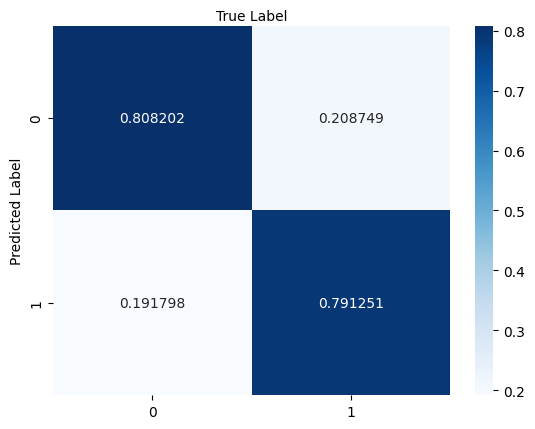

In [ ]:
confusion_matrix(y_test, y_pred.round())

cm = confusion_matrix(y_test, y_pred.round()).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

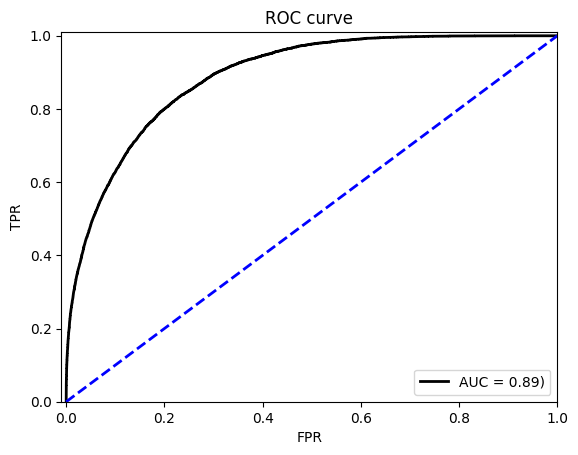

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='black',
lw=lw, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

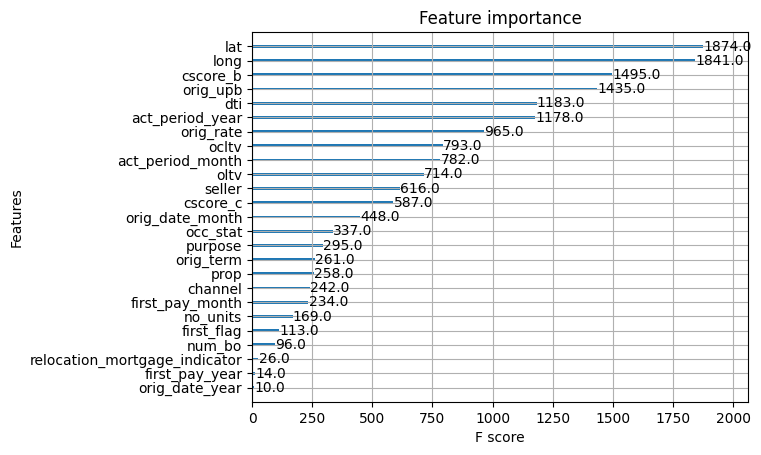

In [ ]:
xgb.plot_importance(model)
plt.show()

In [ ]:
model.save_model('default_predictor_xgb.json')

# Hyperparameter Tuning - An Alternative Approach

When carrying out our initial tuning, we optimised the AUC-PR value for our model.

We chose AUC-PR because the dataset is imbalanced, with less that 10% of observations having defaulted on their loans.

While this method is quite effective at creating a reasonable (though not quite "good" model), we can't balance the trade-off between Sensitivity and Specificity without knowing the impact of a False Positive or False Negative classification.

We'll calculate a rough expected cost of False Negatives, and False positives, and configure our tuning study to optimise for this value.

### Expected Cost

We'll start by calculating the interest the lender will earn on each mortgage.

To do this we must first calculate the monthly payment.

Monthly Payment = (i * P) / (1 - (1+i)^-n)

Where:

P = Principal (ORIG_UPB)

i = Periodic/Monthly Rate ((ORIG_RATE/100)/12)

n = number of periods/months (ORIG_TERM)

Then we make some final calculations to get the total interest paid.

Total Payment = Monthly payment * n

Total interest = Total Payment - A

We'll consider this interest to be the profit a bank can gain on a given loan if the borrower doesn't default. To keep things simple, we won't consider borrowers who pay off their loan in less than the original term.

Next we'll consider the potential loss if the borrower defaults. Again, we will simplify this for now and consider the principal (ORIG_UPB) to be the amount lost by the bank in this case.

In [ ]:
df['MNTHLY_PAYMNT'] = round(((df['ORIG_RATE']/100)/12) * (df['ORIG_UPB']) / (1 - pow((1 + ((df['ORIG_RATE']/100)/12)), -df['ORIG_TERM'])))
df['TOTAL_PAYMNT'] =  round(df['MNTHLY_PAYMNT'] * df['ORIG_TERM'])
df['TOTAL_INTEREST'] = round(df['TOTAL_PAYMNT'] - df['ORIG_UPB'])

In [ ]:
df[['ORIG_UPB', 'ORIG_RATE', 'ORIG_TERM','MNTHLY_PAYMNT', 'TOTAL_PAYMNT', 'TOTAL_INTEREST']]

,ORIG_UPB,ORIG_RATE,ORIG_TERM,MNTHLY_PAYMNT,TOTAL_PAYMNT,TOTAL_INTEREST
0,343000.0,6.625,360,2196.0,790560.0,447560.0
1,400000.0,6.250,360,2463.0,886680.0,486680.0
2,81000.0,6.625,360,519.0,186840.0,105840.0
3,119000.0,6.500,360,752.0,270720.0,151720.0
4,205000.0,6.625,360,1313.0,472680.0,267680.0
...,...,...,...,...,...,...
391176,139000.0,6.500,360,879.0,316440.0,177440.0
391177,47000.0,6.375,180,406.0,73080.0,26080.0
391178,135000.0,6.125,360,820.0,295200.0,160200.0
391179,344000.0,6.250,360,2118.0,762480.0,418480.0


In [ ]:
default_cost = df['ORIG_UPB'].mean()
print(default_cost)

197362.46740630912


In [ ]:
loan_profit = df['TOTAL_INTEREST'].mean()
print(loan_profit)

238064.11145252825


Looking at the Total Interest compared to the loan Principal, we can see that the average profit earned by the lender is higher that the loan principal.

When we consider the opportunity cost of turning down a "good" loan and losing the profits that it would have earned), we can guess that our model won't care too much about correctly identifying defaulters, as the profits from non-defaulters will keep our expected value high.

After 2007, the FED slashed interest rates, so lets do the same and artificially lower all of the interest rates in our dataset by 80%.

In [ ]:
df['MNTHLY_PAYMNT'] = round((((df['ORIG_RATE']*0.2)/100)/12) * (df['ORIG_UPB']) / (1 - pow((1 + (((df['ORIG_RATE']*0.2)/100)/12)), -df['ORIG_TERM'])))
df['TOTAL_PAYMNT'] =  round(df['MNTHLY_PAYMNT'] * df['ORIG_TERM'])
df['TOTAL_INTEREST'] = round(df['TOTAL_PAYMNT'] - df['ORIG_UPB'])

In [ ]:
df[['ORIG_UPB', 'ORIG_RATE', 'ORIG_TERM','MNTHLY_PAYMNT', 'TOTAL_PAYMNT', 'TOTAL_INTEREST']]

,ORIG_UPB,ORIG_RATE,ORIG_TERM,MNTHLY_PAYMNT,TOTAL_PAYMNT,TOTAL_INTEREST
0,343000.0,6.625,360,1155.0,415800.0,72800.0
1,400000.0,6.250,360,1333.0,479880.0,79880.0
2,81000.0,6.625,360,273.0,98280.0,17280.0
3,119000.0,6.500,360,399.0,143640.0,24640.0
4,205000.0,6.625,360,690.0,248400.0,43400.0
...,...,...,...,...,...,...
391176,139000.0,6.500,360,466.0,167760.0,28760.0
391177,47000.0,6.375,180,287.0,51660.0,4660.0
391178,135000.0,6.125,360,448.0,161280.0,26280.0
391179,344000.0,6.250,360,1146.0,412560.0,68560.0


In [ ]:
default_cost = df['ORIG_UPB'].mean()
print(default_cost)

197362.46740630912


In [ ]:
loan_profit = df['TOTAL_INTEREST'].mean()
print(loan_profit)

39019.88093205174


### Tuning

In [ ]:
def objective(trial):
    params = {"objective":"binary:logistic","tree_method": "hist", "device": "gpu", "eval_metric": trial.suggest_categorical('eval_metric', ['error', 'auc', 'aucpr']),
              'max_depth': trial.suggest_int('max_depth', 3, 18),
              'gamma': trial.suggest_float('gamma', 1, 9),
              'reg_alpha': trial.suggest_int('reg_alpha', 40, 180),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
              'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 13)}

    evals = [(dtrain, "train"), (dtest, "validation")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=evals,
        verbose_eval=False,
        early_stopping_rounds=100,
        )



    pred = model.predict(dtest)

    tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()

    ev = (tn * loan_profit) - (fp * loan_profit) - (fn * default_cost)

    # accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", model.best_score)
    print ("EXPECTED VALUE:", ev)
    # print ("ACCURACY", accuracy)
    return ev

In [ ]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-10-20 01:52:21,879] A new study created in memory with name: no-name-e8c6732e-6cfe-484a-b757-4f0215e74f35
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:23,538] Trial 0 finished with value: 1296597739.795897 and parameters: {'eval_metric': 'aucpr', 'max_depth': 14, 'gamma': 4.1399034231487875, 'reg_alpha': 122, 'reg_lambda': 0.7418974948628083, 

SCORE: 0.5229211151964798
EXPECTED VALUE: 1296597739.795897


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:24,873] Trial 1 finished with value: 1502020592.8151822 and parameters: {'eval_metric': 'error', 'max_depth': 14, 'gamma': 6.0247484437029994, 'reg_alpha': 116, 'reg_lambda': 0.8531616896987539, 'min_child_weight': 0, 'colsample_bytree': 0.7511123968482665, 'scale_pos_weight': 10}. Best is trial 1 with value: 1502020592.8151822.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.22911191778720794
EXPECTED VALUE: 1502020592.8151822


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:25,725] Trial 2 finished with value: 1681221394.422381 and parameters: {'eval_metric': 'error', 'max_depth': 5, 'gamma': 2.1642801970671535, 'reg_alpha': 115, 'reg_lambda': 0.5537990917939888, 'min_child_weight': 9, 'colsample_bytree': 0.5596760562212674, 'scale_pos_weight': 7}. Best is trial 2 with value: 1681221394.422381.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(

SCORE: 0.1714811595684851
EXPECTED VALUE: 1681221394.422381


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:27,033] Trial 3 finished with value: 1367943899.418659 and parameters: {'eval_metric': 'auc', 'max_depth': 5, 'gamma': 4.94484630965764, 'reg_alpha': 114, 'reg_lambda': 0.7454494662013972, 'min_child_weight': 6, 'colsample_bytree': 0.6665513268686065, 'scale_pos_weight': 10}. Best is trial 2 with value: 1681221394.422381.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(sms

SCORE: 0.8827242000975339
EXPECTED VALUE: 1367943899.418659


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:28,713] Trial 4 finished with value: 1486957275.3326626 and parameters: {'eval_metric': 'aucpr', 'max_depth': 11, 'gamma': 3.1437180428405895, 'reg_alpha': 117, 'reg_lambda': 0.7315531668799135, 'min_child_weight': 8, 'colsample_bytree': 0.5024679092864806, 'scale_pos_weight': 10}. Best is trial 2 with value: 1681221394.422381.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.52249722468565
EXPECTED VALUE: 1486957275.3326626


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:30,200] Trial 5 finished with value: 1507065472.769147 and parameters: {'eval_metric': 'auc', 'max_depth': 18, 'gamma': 7.589730999088214, 'reg_alpha': 69, 'reg_lambda': 0.48523653723977456, 'min_child_weight': 2, 'colsample_bytree': 0.5270329009121275, 'scale_pos_weight': 10}. Best is trial 2 with value: 1681221394.422381.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(s

SCORE: 0.8870258910524251
EXPECTED VALUE: 1507065472.769147


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:31,339] Trial 6 finished with value: 1244665636.9665806 and parameters: {'eval_metric': 'aucpr', 'max_depth': 7, 'gamma': 7.756406688346801, 'reg_alpha': 92, 'reg_lambda': 0.4838250479935633, 'min_child_weight': 9, 'colsample_bytree': 0.8250609592982804, 'scale_pos_weight': 12}. Best is trial 2 with value: 1681221394.422381.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(

SCORE: 0.5130680671208367
EXPECTED VALUE: 1244665636.9665806


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:32,127] Trial 7 finished with value: 2021483872.1171198 and parameters: {'eval_metric': 'error', 'max_depth': 12, 'gamma': 6.34168771320942, 'reg_alpha': 80, 'reg_lambda': 0.305278873241527, 'min_child_weight': 2, 'colsample_bytree': 0.9267107552763788, 'scale_pos_weight': 4}. Best is trial 7 with value: 2021483872.1171198.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(s

SCORE: 0.09650800143156603
EXPECTED VALUE: 2021483872.1171198


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:33,409] Trial 8 finished with value: 1562352593.9328723 and parameters: {'eval_metric': 'error', 'max_depth': 15, 'gamma': 6.976249993502875, 'reg_alpha': 55, 'reg_lambda': 0.08184384176176218, 'min_child_weight': 0, 'colsample_bytree': 0.5914126673494429, 'scale_pos_weight': 10}. Best is trial 7 with value: 2021483872.1171198.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.21990899330231606
EXPECTED VALUE: 1562352593.9328723


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:34,284] Trial 9 finished with value: 1875863824.9249835 and parameters: {'eval_metric': 'auc', 'max_depth': 15, 'gamma': 5.250158062008241, 'reg_alpha': 92, 'reg_lambda': 0.12015532749120295, 'min_child_weight': 0, 'colsample_bytree': 0.9892308368192777, 'scale_pos_weight': 1}. Best is trial 7 with value: 2021483872.1171198.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(

SCORE: 0.8745283379101818
EXPECTED VALUE: 1875863824.9249835


[I 2023-10-20 01:52:34,948] Trial 10 finished with value: 2001757118.9147422 and parameters: {'eval_metric': 'error', 'max_depth': 9, 'gamma': 6.5620419530602465, 'reg_alpha': 174, 'reg_lambda': 0.27159963787528457, 'min_child_weight': 4, 'colsample_bytree': 0.9852638638707235, 'scale_pos_weight': 2}. Best is trial 7 with value: 2021483872.1171198.


SCORE: 0.09107827598547984
EXPECTED VALUE: 2001757118.9147422


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:35,598] Trial 11 finished with value: 1991839208.1640136 and parameters: {'eval_metric': 'error', 'max_depth': 9, 'gamma': 8.778136532836008, 'reg_alpha': 179, 'reg_lambda': 0.2832415929780824, 'min_child_weight': 4, 'colsample_bytree': 0.9982973611178818, 'scale_pos_weight': 2}. Best is trial 7 with value:

SCORE: 0.09101692315558055
EXPECTED VALUE: 1991839208.1640136


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:36,326] Trial 12 finished with value: 1972993879.6350608 and parameters: {'eval_metric': 'error', 'max_depth': 11, 'gamma': 6.166561874005236, 'reg_alpha': 180, 'reg_lambda': 0.2570931115075926, 'min_child_weight': 4, 'colsample_bytree': 0.9130886000855664, 'scale_pos_weight': 4}. Best is trial 7 with value: 2021483872.1171198.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.0960171787923718
EXPECTED VALUE: 1972993879.6350608


[I 2023-10-20 01:52:37,014] Trial 13 finished with value: 1983292936.9441252 and parameters: {'eval_metric': 'error', 'max_depth': 9, 'gamma': 6.525611721010754, 'reg_alpha': 152, 'reg_lambda': 0.2894428848875243, 'min_child_weight': 3, 'colsample_bytree': 0.8985358030936832, 'scale_pos_weight': 4}. Best is trial 7 with value: 2021483872.1171198.


SCORE: 0.09531162124853008
EXPECTED VALUE: 1983292936.9441252


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:37,740] Trial 14 finished with value: 2011966451.6666932 and parameters: {'eval_metric': 'error', 'max_depth': 8, 'gamma': 5.119125313280769, 'reg_alpha': 41, 'reg_lambda': 0.011373677396067039, 'min_child_weight': 6, 'colsample_bytree': 0.9168113250314132, 'scale_pos_weight': 4}. Best is trial 7 with value: 2021483872.1171198.


SCORE: 0.09351193823815124
EXPECTED VALUE: 2011966451.6666932


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:38,747] Trial 15 finished with value: 1877116939.7030087 and parameters: {'eval_metric': 'error', 'max_depth': 12, 'gamma': 4.033320112262777, 'reg_alpha': 47, 'reg_lambda': 0.013303728699543771, 'min_child_weight': 6, 'colsample_bytree': 0.8448103806315436, 'scale_pos_weight': 6}. Best is trial 7 with valu

SCORE: 0.10264328442149394
EXPECTED VALUE: 1877116939.7030087


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:39,318] Trial 16 finished with value: 1826048608.7851906 and parameters: {'eval_metric': 'error', 'max_depth': 3, 'gamma': 1.538017533321569, 'reg_alpha': 71, 'reg_lambda': 0.12196901131313176, 'min_child_weight': 7, 'colsample_bytree': 0.9194618697976863, 'scale_pos_weight': 5}. Best is trial 7 with value: 2021483872.1171198.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.09840993915844368
EXPECTED VALUE: 1826048608.7851906


[I 2023-10-20 01:52:39,969] Trial 17 finished with value: 2051960896.1473055 and parameters: {'eval_metric': 'error', 'max_depth': 7, 'gamma': 5.283818379290691, 'reg_alpha': 84, 'reg_lambda': 0.02322272158018699, 'min_child_weight': 6, 'colsample_bytree': 0.7921031576606081, 'scale_pos_weight': 3}. Best is trial 17 with value: 2051960896.1473055.


SCORE: 0.0947492203077867
EXPECTED VALUE: 2051960896.1473055


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:41,240] Trial 18 finished with value: 1690453264.7640545 and parameters: {'eval_metric': 'aucpr', 'max_depth': 6, 'gamma': 5.458519624712855, 'reg_alpha': 92, 'reg_lambda': 0.1893301387349259, 'min_child_weight': 2, 'colsample_bytree': 0.7700355009288293, 'scale_pos_weight': 7}. Best is trial 17 with value:

SCORE: 0.512564140528033
EXPECTED VALUE: 1690453264.7640545


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:42,552] Trial 19 finished with value: 1992509883.142346 and parameters: {'eval_metric': 'auc', 'max_depth': 3, 'gamma': 4.3749700532746605, 'reg_alpha': 75, 'reg_lambda': 0.36639548601001504, 'min_child_weight': 2, 'colsample_bytree': 0.7051100112321147, 'scale_pos_weight': 2}. Best is trial 17 with value: 2051960896.1473055.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.8733084662442708
EXPECTED VALUE: 1992509883.142346


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:43,612] Trial 20 finished with value: 2054603408.7454548 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 3.1686553043308674, 'reg_alpha': 138, 'reg_lambda': 0.18672073067076114, 'min_child_weight': 10, 'colsample_bytree': 0.8116903199065466, 'scale_pos_weight': 3}. Best is trial 20 with value: 2054603408.7454548.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warning

SCORE: 0.09293931182575796
EXPECTED VALUE: 2054603408.7454548


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:44,648] Trial 21 finished with value: 2051010149.202712 and parameters: {'eval_metric': 'error', 'max_depth': 18, 'gamma': 3.315804949616506, 'reg_alpha': 136, 'reg_lambda': 0.1645955328111647, 'min_child_weight': 10, 'colsample_bytree': 0.8245640276587254, 'scale_pos_weight': 3}. Best is trial 20 with value: 2054603408.7454548.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09313359578710569
EXPECTED VALUE: 2051010149.202712


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:45,670] Trial 22 finished with value: 1840881976.4421515 and parameters: {'eval_metric': 'error', 'max_depth': 18, 'gamma': 3.2210064935763656, 'reg_alpha': 137, 'reg_lambda': 0.1252753082012676, 'min_child_weight': 10, 'colsample_bytree': 0.8040899642947443, 'scale_pos_weight': 1}. Best is trial 20 with value: 2054603408.7454548.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.08721304770182525
EXPECTED VALUE: 1840881976.4421515


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:46,627] Trial 23 finished with value: 2057046367.6192007 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 2.7887432231936025, 'reg_alpha': 149, 'reg_lambda': 0.004393680446505694, 'min_child_weight': 10, 'colsample_bytree': 0.7941248082775665, 'scale_pos_weight': 3}. Best is trial 23 with value: 2057046367.6192007.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnin

SCORE: 0.0944424561582903
EXPECTED VALUE: 2057046367.6192007


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:47,702] Trial 24 finished with value: 1854190402.1999307 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 2.2654909659795197, 'reg_alpha': 159, 'reg_lambda': 0.0028674626010568027, 'min_child_weight': 8, 'colsample_bytree': 0.7095681134472719, 'scale_pos_weight': 6}. Best is trial 23 with value: 2057046367.6192007.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnin

SCORE: 0.10999539853775755
EXPECTED VALUE: 1854190402.1999307


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:48,745] Trial 25 finished with value: 2052031527.100933 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 1.1141042299949344, 'reg_alpha': 136, 'reg_lambda': 0.06198267722172776, 'min_child_weight': 9, 'colsample_bytree': 0.7844764993965243, 'scale_pos_weight': 3}. Best is trial 23 with value: 2057046367.6192007.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09457538728973874
EXPECTED VALUE: 2052031527.100933


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:49,803] Trial 26 finished with value: 2060572426.7053099 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 1.2135729808426057, 'reg_alpha': 135, 'reg_lambda': 0.19276950015964014, 'min_child_weight': 9, 'colsample_bytree': 0.8569611797049844, 'scale_pos_weight': 3}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09219285239531673
EXPECTED VALUE: 2060572426.7053099


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:50,833] Trial 27 finished with value: 1919870507.0478115 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 2.206096141326956, 'reg_alpha': 157, 'reg_lambda': 0.20629693724426962, 'min_child_weight': 10, 'colsample_bytree': 0.85882555209789, 'scale_pos_weight': 5}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09861444859144128
EXPECTED VALUE: 1919870507.0478115


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:52,470] Trial 28 finished with value: 1688134846.147091 and parameters: {'eval_metric': 'aucpr', 'max_depth': 13, 'gamma': 1.499784561448467, 'reg_alpha': 146, 'reg_lambda': 0.09043015462254307, 'min_child_weight': 8, 'colsample_bytree': 0.7334103744212552, 'scale_pos_weight': 8}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.5244453336773531
EXPECTED VALUE: 1688134846.147091


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:53,792] Trial 29 finished with value: 1930953796.6752615 and parameters: {'eval_metric': 'auc', 'max_depth': 16, 'gamma': 2.7138067347455044, 'reg_alpha': 125, 'reg_lambda': 0.19098435180703913, 'min_child_weight': 9, 'colsample_bytree': 0.8555777393329316, 'scale_pos_weight': 5}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.883205073110738
EXPECTED VALUE: 1930953796.6752615


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:54,787] Trial 30 finished with value: 1850556715.6563036 and parameters: {'eval_metric': 'aucpr', 'max_depth': 14, 'gamma': 3.850187875077795, 'reg_alpha': 129, 'reg_lambda': 0.39829279730550377, 'min_child_weight': 10, 'colsample_bytree': 0.8735872884437608, 'scale_pos_weight': 1}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.4867204210119768
EXPECTED VALUE: 1850556715.6563036


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:56,118] Trial 31 finished with value: 2058376474.067884 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 1.1591557287517382, 'reg_alpha': 167, 'reg_lambda': 0.06744103280450744, 'min_child_weight': 9, 'colsample_bytree': 0.7840315336213102, 'scale_pos_weight': 3}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09501508257068357
EXPECTED VALUE: 2058376474.067884


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:57,537] Trial 32 finished with value: 2053781728.1831355 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 1.208539991510887, 'reg_alpha': 167, 'reg_lambda': 0.06691377350428798, 'min_child_weight': 8, 'colsample_bytree': 0.7652160435016092, 'scale_pos_weight': 3}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09498440615573393
EXPECTED VALUE: 2053781728.1831355


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:52:58,595] Trial 33 finished with value: 2025934366.884889 and parameters: {'eval_metric': 'error', 'max_depth': 15, 'gamma': 1.7686765995398646, 'reg_alpha': 146, 'reg_lambda': 0.1527202389533762, 'min_child_weight': 9, 'colsample_bytree': 0.8066521736428963, 'scale_pos_weight': 2}. Best is trial 26 with value: 2060572426.7053099.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09150774579477479
EXPECTED VALUE: 2025934366.884889


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:52:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:00,003] Trial 34 finished with value: 1852115559.3222938 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 1.741025924300172, 'reg_alpha': 166, 'reg_lambda': 0.198502860033076, 'min_child_weight': 7, 'colsample_bytree': 0.7451539608651325, 'scale_pos_weight': 6}. Best is trial 26 with value: 2060572426.7053099.


SCORE: 0.10922848816401656
EXPECTED VALUE: 1852115559.3222938


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:01,231] Trial 35 finished with value: 2069474033.4975586 and parameters: {'eval_metric': 'error', 'max_depth': 14, 'gamma': 2.618677149023801, 'reg_alpha': 109, 'reg_lambda': 0.07201021777385641, 'min_child_weight': 10, 'colsample_bytree': 0.8228463999219455, 'scale_pos_weight': 3}. Best is trial 35 with va

SCORE: 0.09239736182831433
EXPECTED VALUE: 2069474033.4975586


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:03,237] Trial 36 finished with value: 1740165140.8857381 and parameters: {'eval_metric': 'error', 'max_depth': 14, 'gamma': 1.0075891424565775, 'reg_alpha': 107, 'reg_lambda': 0.07033234146484157, 'min_child_weight': 7, 'colsample_bytree': 0.8337344683512786, 'scale_pos_weight': 8}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.18932460759752542
EXPECTED VALUE: 1740165140.8857381


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:04,536] Trial 37 finished with value: 2048254978.01802 and parameters: {'eval_metric': 'auc', 'max_depth': 13, 'gamma': 2.3406243478527067, 'reg_alpha': 105, 'reg_lambda': 0.12011614867783717, 'min_child_weight': 8, 'colsample_bytree': 0.7793960795756583, 'scale_pos_weight': 2}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.8825794592043442
EXPECTED VALUE: 2048254978.01802


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:06,519] Trial 38 finished with value: 1391453759.2959683 and parameters: {'eval_metric': 'error', 'max_depth': 13, 'gamma': 2.6560806012882736, 'reg_alpha': 115, 'reg_lambda': 0.029798527700551664, 'min_child_weight': 9, 'colsample_bytree': 0.8852362014018849, 'scale_pos_weight': 13}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnin

SCORE: 0.24721100260749526
EXPECTED VALUE: 1391453759.2959683


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:08,317] Trial 39 finished with value: 2006924310.7839737 and parameters: {'eval_metric': 'aucpr', 'max_depth': 15, 'gamma': 1.9756673489399799, 'reg_alpha': 165, 'reg_lambda': 0.07889910746309507, 'min_child_weight': 10, 'colsample_bytree': 0.847928091091111, 'scale_pos_weight': 4}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.5145457410102952
EXPECTED VALUE: 2006924310.7839737


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:09,757] Trial 40 finished with value: 1874661545.618577 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 1.494709814106262, 'reg_alpha': 100, 'reg_lambda': 0.23335546743453, 'min_child_weight': 9, 'colsample_bytree': 0.7935217947141878, 'scale_pos_weight': 1}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.08618027506518738
EXPECTED VALUE: 1874661545.618577


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:10,601] Trial 41 finished with value: 2042592550.615121 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 2.8372207474834257, 'reg_alpha': 145, 'reg_lambda': 0.16432260631690204, 'min_child_weight': 10, 'colsample_bytree': 0.8220833836318308, 'scale_pos_weight': 3}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09292908635410808
EXPECTED VALUE: 2042592550.615121


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:11,704] Trial 42 finished with value: 1944040750.4124727 and parameters: {'eval_metric': 'error', 'max_depth': 18, 'gamma': 2.0561339572533255, 'reg_alpha': 123, 'reg_lambda': 0.2306164250358583, 'min_child_weight': 10, 'colsample_bytree': 0.8100857893169446, 'scale_pos_weight': 5}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.096681834449614
EXPECTED VALUE: 1944040750.4124727


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:12,548] Trial 43 finished with value: 2037247446.547428 and parameters: {'eval_metric': 'error', 'max_depth': 16, 'gamma': 3.4467296111712518, 'reg_alpha': 151, 'reg_lambda': 0.13563112197254923, 'min_child_weight': 9, 'colsample_bytree': 0.866875733344654, 'scale_pos_weight': 3}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09263254767626157
EXPECTED VALUE: 2037247446.547428


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:13,647] Trial 44 finished with value: 2019316863.2868934 and parameters: {'eval_metric': 'error', 'max_depth': 17, 'gamma': 2.5055861460942577, 'reg_alpha': 129, 'reg_lambda': 0.05009803151156764, 'min_child_weight': 9, 'colsample_bytree': 0.7584095553323412, 'scale_pos_weight': 4}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09645687407331663
EXPECTED VALUE: 2019316863.2868934


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:14,601] Trial 45 finished with value: 2026913770.4136844 and parameters: {'eval_metric': 'error', 'max_depth': 15, 'gamma': 2.9928187513273534, 'reg_alpha': 140, 'reg_lambda': 0.10118342878939937, 'min_child_weight': 10, 'colsample_bytree': 0.8302638931974283, 'scale_pos_weight': 2}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warning

SCORE: 0.09135436372002659
EXPECTED VALUE: 2026913770.4136844


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:16,285] Trial 46 finished with value: 1436210038.733532 and parameters: {'eval_metric': 'auc', 'max_depth': 14, 'gamma': 2.5015731195822677, 'reg_alpha': 173, 'reg_lambda': 0.3257200351733724, 'min_child_weight': 8, 'colsample_bytree': 0.8065400835918288, 'scale_pos_weight': 11}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.8851928330380229
EXPECTED VALUE: 1436210038.733532


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:17,460] Trial 47 finished with value: 1997913529.1656651 and parameters: {'eval_metric': 'error', 'max_depth': 18, 'gamma': 2.975647842279021, 'reg_alpha': 157, 'reg_lambda': 0.001866830995068014, 'min_child_weight': 7, 'colsample_bytree': 0.8928571529093824, 'scale_pos_weight': 4}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09451403445983945
EXPECTED VALUE: 1997913529.1656651


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:18,544] Trial 48 finished with value: 2047382962.2610383 and parameters: {'eval_metric': 'error', 'max_depth': 15, 'gamma': 1.8922240212034864, 'reg_alpha': 112, 'reg_lambda': 0.15995952784136497, 'min_child_weight': 9, 'colsample_bytree': 0.84098813939818, 'scale_pos_weight': 2}. Best is trial 35 with value: 2069474033.4975586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09130323636177719
EXPECTED VALUE: 2047382962.2610383


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:19,457] Trial 49 finished with value: 2071033733.1063418 and parameters: {'eval_metric': 'error', 'max_depth': 10, 'gamma': 1.3858423807240872, 'reg_alpha': 119, 'reg_lambda': 0.241472182135032, 'min_child_weight': 10, 'colsample_bytree': 0.7804335617248592, 'scale_pos_weight': 3}. Best is trial 49 with value: 2071033733.1063418.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09498440615573393
EXPECTED VALUE: 2071033733.1063418


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:20,571] Trial 50 finished with value: 1881918147.8434403 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.3252112012570383, 'reg_alpha': 121, 'reg_lambda': 0.24602681848762595, 'min_child_weight': 5, 'colsample_bytree': 0.7803233483230594, 'scale_pos_weight': 1}. Best is trial 49 with value: 2071033733.1063418.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.4961823859938225
EXPECTED VALUE: 1881918147.8434403


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:21,457] Trial 51 finished with value: 2061688709.627366 and parameters: {'eval_metric': 'error', 'max_depth': 12, 'gamma': 1.6833766153019558, 'reg_alpha': 129, 'reg_lambda': 0.05002515181723746, 'min_child_weight': 10, 'colsample_bytree': 0.7550991543384731, 'scale_pos_weight': 3}. Best is trial 49 with value: 2071033733.1063418.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09432997597014162
EXPECTED VALUE: 2061688709.627366


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:22,477] Trial 52 finished with value: 2018967947.4212508 and parameters: {'eval_metric': 'error', 'max_depth': 12, 'gamma': 1.0231583477979953, 'reg_alpha': 131, 'reg_lambda': 0.0474473379256868, 'min_child_weight': 10, 'colsample_bytree': 0.7397868591866078, 'scale_pos_weight': 4}. Best is trial 49 with value: 2071033733.1063418.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.0965693542614653
EXPECTED VALUE: 2018967947.4212508


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:23,315] Trial 53 finished with value: 2045575564.9901862 and parameters: {'eval_metric': 'error', 'max_depth': 11, 'gamma': 1.7060469226847559, 'reg_alpha': 118, 'reg_lambda': 0.10787582357346495, 'min_child_weight': 9, 'colsample_bytree': 0.7686729668150629, 'scale_pos_weight': 2}. Best is trial 49 with value: 2071033733.1063418.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09061812976123523
EXPECTED VALUE: 2045575564.9901862


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:24,253] Trial 54 finished with value: 2076784949.2283273 and parameters: {'eval_metric': 'error', 'max_depth': 10, 'gamma': 1.3232902183038728, 'reg_alpha': 109, 'reg_lambda': 0.04782581359700411, 'min_child_weight': 10, 'colsample_bytree': 0.790817294075695, 'scale_pos_weight': 3}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09438110332839102
EXPECTED VALUE: 2076784949.2283273


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:25,224] Trial 55 finished with value: 2035208174.5114703 and parameters: {'eval_metric': 'error', 'max_depth': 10, 'gamma': 1.359988838744537, 'reg_alpha': 99, 'reg_lambda': 0.10228125667179248, 'min_child_weight': 9, 'colsample_bytree': 0.752691285898997, 'scale_pos_weight': 4}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.09590469860422313
EXPECTED VALUE: 2035208174.5114703


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:26,333] Trial 56 finished with value: 1965081590.2915819 and parameters: {'eval_metric': 'error', 'max_depth': 12, 'gamma': 1.5992908767667244, 'reg_alpha': 101, 'reg_lambda': 0.06341883754688203, 'min_child_weight': 1, 'colsample_bytree': 0.7308069939107092, 'scale_pos_weight': 5}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.09840993915844368
EXPECTED VALUE: 1965081590.2915819


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:27,165] Trial 57 finished with value: 2063455919.5830383 and parameters: {'eval_metric': 'error', 'max_depth': 10, 'gamma': 1.983702154822637, 'reg_alpha': 110, 'reg_lambda': 0.1409426697448041, 'min_child_weight': 10, 'colsample_bytree': 0.6708782866991534, 'scale_pos_weight': 3}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09482079860933586
EXPECTED VALUE: 2063455919.5830383


[I 2023-10-20 01:53:27,951] Trial 58 finished with value: 2037882407.072583 and parameters: {'eval_metric': 'error', 'max_depth': 10, 'gamma': 2.045676338193327, 'reg_alpha': 110, 'reg_lambda': 0.14271043907153938, 'min_child_weight': 10, 'colsample_bytree': 0.6507438434341393, 'scale_pos_weight': 2}. Best is trial 54 with value: 2076784949.2283273.


SCORE: 0.09112940334372922
EXPECTED VALUE: 2037882407.072583


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:29,177] Trial 59 finished with value: 2058649685.0401578 and parameters: {'eval_metric': 'auc', 'max_depth': 8, 'gamma': 1.8675015881021335, 'reg_alpha': 116, 'reg_lambda': 0.2580482085033903, 'min_child_weight': 10, 'colsample_bytree': 0.673451332068092, 'scale_pos_weight': 3}. Best is trial 54 with value:

SCORE: 0.8822857196049922
EXPECTED VALUE: 2058649685.0401578


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:30,252] Trial 60 finished with value: 1879136420.9835343 and parameters: {'eval_metric': 'error', 'max_depth': 11, 'gamma': 1.3917721169060135, 'reg_alpha': 89, 'reg_lambda': 0.22145336295124424, 'min_child_weight': 8, 'colsample_bytree': 0.7172432849370226, 'scale_pos_weight': 1}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.08607802034868858
EXPECTED VALUE: 1879136420.9835343


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:31,541] Trial 61 finished with value: 2055087560.5616112 and parameters: {'eval_metric': 'auc', 'max_depth': 8, 'gamma': 1.8739086269710084, 'reg_alpha': 119, 'reg_lambda': 0.2654314342055863, 'min_child_weight': 10, 'colsample_bytree': 0.6820341998529031, 'scale_pos_weight': 3}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.8821398933407126
EXPECTED VALUE: 2055087560.5616112


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:32,806] Trial 62 finished with value: 2064103416.1196609 and parameters: {'eval_metric': 'auc', 'max_depth': 8, 'gamma': 2.213377014503576, 'reg_alpha': 104, 'reg_lambda': 0.2919184851349646, 'min_child_weight': 10, 'colsample_bytree': 0.6455060203995941, 'scale_pos_weight': 3}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.8825569728137193
EXPECTED VALUE: 2064103416.1196609


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:34,193] Trial 63 finished with value: 2006798270.6959429 and parameters: {'eval_metric': 'auc', 'max_depth': 9, 'gamma': 2.306105486321317, 'reg_alpha': 107, 'reg_lambda': 0.17603966325332737, 'min_child_weight': 10, 'colsample_bytree': 0.6247224492559368, 'scale_pos_weight': 4}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.8832477142886207
EXPECTED VALUE: 2006798270.6959429


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:35,397] Trial 64 finished with value: 2039015151.0538597 and parameters: {'eval_metric': 'auc', 'max_depth': 7, 'gamma': 1.5813727395013413, 'reg_alpha': 93, 'reg_lambda': 0.3014868464267285, 'min_child_weight': 10, 'colsample_bytree': 0.5897149496187379, 'scale_pos_weight': 2}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.8802938267825803
EXPECTED VALUE: 2039015151.0538597


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:36,661] Trial 65 finished with value: 1932745972.1268904 and parameters: {'eval_metric': 'auc', 'max_depth': 11, 'gamma': 2.2546513043985947, 'reg_alpha': 126, 'reg_lambda': 0.13547156718913606, 'min_child_weight': 9, 'colsample_bytree': 0.693410300374709, 'scale_pos_weight': 5}. Best is trial 54 with value: 2076784949.2283273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.8849986128933902
EXPECTED VALUE: 1932745972.1268904


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:37,543] Trial 66 finished with value: 2089416147.1423311 and parameters: {'eval_metric': 'error', 'max_depth': 9, 'gamma': 1.3199327074629812, 'reg_alpha': 95, 'reg_lambda': 0.19641012983045514, 'min_child_weight': 10, 'colsample_bytree': 0.7169151829060348, 'scale_pos_weight': 3}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.09477989672273633
EXPECTED VALUE: 2089416147.1423311


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:38,431] Trial 67 finished with value: 2026875476.6797304 and parameters: {'eval_metric': 'error', 'max_depth': 9, 'gamma': 2.058682855714145, 'reg_alpha': 96, 'reg_lambda': 0.03737156919844257, 'min_child_weight': 10, 'colsample_bytree': 0.7235813473131576, 'scale_pos_weight': 4}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.09684544199601207
EXPECTED VALUE: 2026875476.6797304


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:39,690] Trial 68 finished with value: 2080781985.9568663 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.3983047565846045, 'reg_alpha': 87, 'reg_lambda': 0.10389703149235174, 'min_child_weight': 10, 'colsample_bytree': 0.7075879031218782, 'scale_pos_weight': 3}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.5210646544332147
EXPECTED VALUE: 2080781985.9568663


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:40,937] Trial 69 finished with value: 2073823363.325244 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.3499925331582752, 'reg_alpha': 61, 'reg_lambda': 0.2218389264572207, 'min_child_weight': 9, 'colsample_bytree': 0.7028557056608324, 'scale_pos_weight': 2}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.525308903503478
EXPECTED VALUE: 2073823363.325244


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:42,033] Trial 70 finished with value: 1894760834.4155757 and parameters: {'eval_metric': 'aucpr', 'max_depth': 6, 'gamma': 1.3232170252129014, 'reg_alpha': 56, 'reg_lambda': 0.22373609355407603, 'min_child_weight': 3, 'colsample_bytree': 0.702702523778869, 'scale_pos_weight': 1}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5063182062564513
EXPECTED VALUE: 1894760834.4155757


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:43,262] Trial 71 finished with value: 2053973415.6330614 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.4833433585668128, 'reg_alpha': 83, 'reg_lambda': 0.17461724766759634, 'min_child_weight': 10, 'colsample_bytree': 0.6550718782118884, 'scale_pos_weight': 2}. Best is trial 66 with value: 2089416147.1423311.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings

SCORE: 0.5137749934123178
EXPECTED VALUE: 2053973415.6330614


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:44,607] Trial 72 finished with value: 2097448073.046094 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.068131444307468, 'reg_alpha': 74, 'reg_lambda': 0.10200905634010207, 'min_child_weight': 9, 'colsample_bytree': 0.6873535617802407, 'scale_pos_weight': 3}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.5306082095011521
EXPECTED VALUE: 2097448073.046094


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:46,053] Trial 73 finished with value: 2086835707.7975838 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.1942169156080609, 'reg_alpha': 62, 'reg_lambda': 0.09439319169829152, 'min_child_weight': 9, 'colsample_bytree': 0.7185204562661296, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5291004511779683
EXPECTED VALUE: 2086835707.7975838


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:47,450] Trial 74 finished with value: 2077799412.8690703 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.0340796409931308, 'reg_alpha': 63, 'reg_lambda': 0.08101770199636307, 'min_child_weight': 8, 'colsample_bytree': 0.7191646302903751, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5248010553102732
EXPECTED VALUE: 2077799412.8690703


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:48,931] Trial 75 finished with value: 2070037267.4405873 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.073487592297394, 'reg_alpha': 61, 'reg_lambda': 0.09615143941160725, 'min_child_weight': 8, 'colsample_bytree': 0.718445222572542, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.5223479079987154
EXPECTED VALUE: 2070037267.4405873


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:51,058] Trial 76 finished with value: 1888224146.7352085 and parameters: {'eval_metric': 'aucpr', 'max_depth': 7, 'gamma': 1.0160550349541213, 'reg_alpha': 68, 'reg_lambda': 0.11537806497599017, 'min_child_weight': 9, 'colsample_bytree': 0.6912767436864504, 'scale_pos_weight': 1}. Best is trial 72 with value: 2097448073.046094.


SCORE: 0.5038577048826178
EXPECTED VALUE: 1888224146.7352085


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:53,617] Trial 77 finished with value: 2076697256.1377394 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.3156601578993243, 'reg_alpha': 66, 'reg_lambda': 0.024560621828083388, 'min_child_weight': 8, 'colsample_bytree': 0.7377803381320199, 'scale_pos_weight': 2}. Best is trial 72 with val

SCORE: 0.5247504055750061
EXPECTED VALUE: 2076697256.1377394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:55,543] Trial 78 finished with value: 2073998095.1651895 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.236612102193178, 'reg_alpha': 76, 'reg_lambda': 0.028637635250078716, 'min_child_weight': 8, 'colsample_bytree': 0.7360966418945797, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5206914717616289
EXPECTED VALUE: 2073998095.1651895


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:57,741] Trial 79 finished with value: 1888610367.2332861 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.6586922190383842, 'reg_alpha': 75, 'reg_lambda': 0.019832365868700158, 'min_child_weight': 8, 'colsample_bytree': 0.7394756010359527, 'scale_pos_weight': 1}. Best is trial 72 with value: 2097448073.046094.


SCORE: 0.5053386308834819
EXPECTED VALUE: 1888610367.2332861


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:53:59,338] Trial 80 finished with value: 2059608739.5464976 and parameters: {'eval_metric': 'aucpr', 'max_depth': 6, 'gamma': 1.209498765129473, 'reg_alpha': 76, 'reg_lambda': 0.030013089244298553, 'min_child_weight': 7, 'colsample_bytree': 0.7284788011895877, 'scale_pos_weight': 2}. Best is trial 72 with valu

SCORE: 0.5132275897162715
EXPECTED VALUE: 2059608739.5464976


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:01,288] Trial 81 finished with value: 2075329297.2423713 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.2589603066170905, 'reg_alpha': 65, 'reg_lambda': 0.08646290129799884, 'min_child_weight': 8, 'colsample_bytree': 0.7111045627856716, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5254159055189039
EXPECTED VALUE: 2075329297.2423713


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:04,755] Trial 82 finished with value: 2066815006.5766985 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.1650741304120997, 'reg_alpha': 67, 'reg_lambda': 0.08524775041331845, 'min_child_weight': 8, 'colsample_bytree': 0.7140329137169243, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5206974392614387
EXPECTED VALUE: 2066815006.5766985


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:08,496] Trial 83 finished with value: 1604995630.231865 and parameters: {'eval_metric': 'aucpr', 'max_depth': 7, 'gamma': 1.541608354562024, 'reg_alpha': 51, 'reg_lambda': 0.03904216892700255, 'min_child_weight': 6, 'colsample_bytree': 0.7422440358485939, 'scale_pos_weight': 9}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.5279772724100051
EXPECTED VALUE: 1604995630.231865


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:09,816] Trial 84 finished with value: 1914955171.8479087 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.0194917671280408, 'reg_alpha': 64, 'reg_lambda': 0.0864125712228934, 'min_child_weight': 8, 'colsample_bytree': 0.697000011942714, 'scale_pos_weight': 1}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.5144247124477905
EXPECTED VALUE: 1914955171.8479087


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:10,913] Trial 85 finished with value: 2048654776.8925736 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.7924954237987314, 'reg_alpha': 87, 'reg_lambda': 0.005490034982336481, 'min_child_weight': 7, 'colsample_bytree': 0.7112155937853011, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.5086781279700363
EXPECTED VALUE: 2048654776.8925736


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:12,120] Trial 86 finished with value: 1898152205.3654199 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.177850293509604, 'reg_alpha': 80, 'reg_lambda': 0.1180417222706647, 'min_child_weight': 8, 'colsample_bytree': 0.7292115553046856, 'scale_pos_weight': 1}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn

SCORE: 0.5078450077611593
EXPECTED VALUE: 1898152205.3654199


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:13,360] Trial 87 finished with value: 2067040621.4255557 and parameters: {'eval_metric': 'aucpr', 'max_depth': 8, 'gamma': 1.282480849694788, 'reg_alpha': 72, 'reg_lambda': 0.06600153152428401, 'min_child_weight': 8, 'colsample_bytree': 0.6865514469012636, 'scale_pos_weight': 2}. Best is trial 72 with value: 2097448073.046094.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.5201331941624172
EXPECTED VALUE: 2067040621.4255557


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:14,734] Trial 88 finished with value: 2100174938.5858452 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.6372845766415256, 'reg_alpha': 44, 'reg_lambda': 0.030251176382249723, 'min_child_weight': 7, 'colsample_bytree': 0.7508752606779744, 'scale_pos_weight': 3}. Best is trial 88 with value: 2100174938.5858452.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.

SCORE: 0.5306002083089738
EXPECTED VALUE: 2100174938.5858452


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:16,051] Trial 89 finished with value: 2092063877.2917194 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.4943273215511415, 'reg_alpha': 46, 'reg_lambda': 0.08725642974696908, 'min_child_weight': 5, 'colsample_bytree': 0.7626685941391956, 'scale_pos_weight': 3}. Best is trial 88 with value: 2100174938.5858452.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.5311685698703846
EXPECTED VALUE: 2092063877.2917194


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:17,461] Trial 90 finished with value: 2019909642.1148596 and parameters: {'eval_metric': 'aucpr', 'max_depth': 5, 'gamma': 1.6037961712948756, 'reg_alpha': 40, 'reg_lambda': 0.14514020475190398, 'min_child_weight': 6, 'colsample_bytree': 0.7516593305968872, 'scale_pos_weight': 4}. Best is trial 88 with value: 2100174938.5858452.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.5207954251586183
EXPECTED VALUE: 2019909642.1148596


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:18,856] Trial 91 finished with value: 2100561159.0839229 and parameters: {'eval_metric': 'aucpr', 'max_depth': 9, 'gamma': 1.4786263511179656, 'reg_alpha': 56, 'reg_lambda': 0.08796980113180408, 'min_child_weight': 5, 'colsample_bytree': 0.7683969458725133, 'scale_pos_weight': 3}. Best is trial 91 with value: 2100561159.0839229.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.w

SCORE: 0.5295474043423132
EXPECTED VALUE: 2100561159.0839229


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:20,799] Trial 92 finished with value: 2102966265.510985 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.4844647518053842, 'reg_alpha': 44, 'reg_lambda': 0.054271959024950495, 'min_child_weight': 5, 'colsample_bytree': 0.7650716006392377, 'scale_pos_weight': 3}. Best is trial 92 with value: 2102966265.510985.


SCORE: 0.5327629094650097
EXPECTED VALUE: 2102966265.510985


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:23,615] Trial 93 finished with value: 2095618592.9620302 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.7977457057818451, 'reg_alpha': 45, 'reg_lambda': 0.05304337527148105, 'min_child_weight': 5, 'colsample_bytree': 0.7675558940568723, 'scale_pos_weight': 3}. Best is trial 92 with val

SCORE: 0.5311641485939437
EXPECTED VALUE: 2095618592.9620302


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:25,850] Trial 94 finished with value: 2045570453.9659262 and parameters: {'eval_metric': 'aucpr', 'max_depth': 11, 'gamma': 1.7866644929022129, 'reg_alpha': 44, 'reg_lambda': 0.11588469992304984, 'min_child_weight': 5, 'colsample_bytree': 0.7649247191350114, 'scale_pos_weight': 4}. Best is trial 92 with val

SCORE: 0.5303236824596557
EXPECTED VALUE: 2045570453.9659262


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:27,479] Trial 95 finished with value: 2090449316.3627815 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.514898721848155, 'reg_alpha': 49, 'reg_lambda': 0.1598872491944509, 'min_child_weight': 4, 'colsample_bytree': 0.7658297134611713, 'scale_pos_weight': 3}. Best is trial 92 with value: 2102966265.510985.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.5309629922636834
EXPECTED VALUE: 2090449316.3627815


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:29,057] Trial 96 finished with value: 2093896644.2612786 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.534090317749392, 'reg_alpha': 48, 'reg_lambda': 0.10850581096829895, 'min_child_weight': 4, 'colsample_bytree': 0.7686421283191605, 'scale_pos_weight': 3}. Best is trial 92 with value: 2102966265.510985.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.wa

SCORE: 0.5302816895769428
EXPECTED VALUE: 2093896644.2612786


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:30,733] Trial 97 finished with value: 2089136218.787568 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.968408501838175, 'reg_alpha': 48, 'reg_lambda': 0.15758163851302065, 'min_child_weight': 4, 'colsample_bytree': 0.7730512322467924, 'scale_pos_weight': 3}. Best is trial 92 with value: 2102966265.510985.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.5301317606721339
EXPECTED VALUE: 2089136218.787568


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:32,545] Trial 98 finished with value: 2040425451.4368858 and parameters: {'eval_metric': 'aucpr', 'max_depth': 11, 'gamma': 2.121400686829042, 'reg_alpha': 49, 'reg_lambda': 0.1598895104021842, 'min_child_weight': 4, 'colsample_bytree': 0.7704051527696368, 'scale_pos_weight': 4}. Best is trial 92 with value: 2102966265.510985.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

SCORE: 0.5325539887447388
EXPECTED VALUE: 2040425451.4368858


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-10-20 01:54:33,803] Trial 99 finished with value: 2100749469.300345 and parameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.9216341024874795, 'reg_alpha': 44, 'reg_lambda': 0.19897807398846118, 'min_child_weight': 4, 'colsample_bytree': 0.758299740915572, 'scale_pos_weight': 3}. Best is trial 92 with value: 2102966265.510985.


SCORE: 0.5320790412394212
EXPECTED VALUE: 2100749469.300345
Score: 2102966265.510985
Best hyperparameters: {'eval_metric': 'aucpr', 'max_depth': 10, 'gamma': 1.4844647518053842, 'reg_alpha': 44, 'reg_lambda': 0.054271959024950495, 'min_child_weight': 5, 'colsample_bytree': 0.7650716006392377, 'scale_pos_weight': 3}


### Final Evaluation

In [ ]:
trial.params.update({"objective":"binary:logistic","tree_method": "hist", "device": "gpu"})

n = 5000
evals = [(dtrain, "train"), (dtest, "validation")]

model = xgb.train(
   params=trial.params,
   dtrain=dtrain,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   early_stopping_rounds=100,
)

[0]	train-aucpr:0.31203	validation-aucpr:0.30513
[100]	train-aucpr:0.59139	validation-aucpr:0.53274
[151]	train-aucpr:0.59139	validation-aucpr:0.53274


In [ ]:
y_pred = model.predict(dtest)

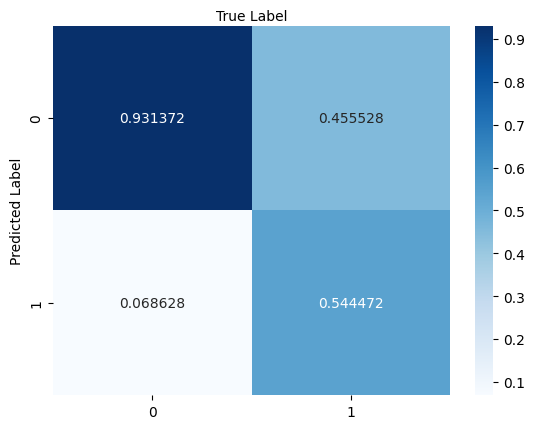

In [ ]:
confusion_matrix(y_test, y_pred.round())

cm = confusion_matrix(y_test, y_pred.round()).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')